# Import Libraries

Importamos todas las librerías necesarias

In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

from datetime import datetime
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
import lightgbm as lgbm
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import plot_importance
from sklearn import metrics
from math import sqrt

from sklearn.tree import export_graphviz
import graphviz

import time 

import warnings
warnings.filterwarnings("ignore")


De los apartados anteriores de EDA y clustering reutilizamos las siguientes listas y diccionarios

In [ ]:
prod_cols = ["short_term_deposit", "loans", "mortgage", "funds", "securities","long_term_deposit", "em_account_pp", "credit_card", "payroll_account", "emc_account", "debit_card", "em_account_p", "em_acount", "pension_plan"]

buckets =   {'cuenta' : ['em_acount', 'emc_account', 'payroll_account'],
             'ahorro':  ['funds', 'pension_plan', 'short_term_deposit', 'long_term_deposit', 'securities'],
             'financiacion': ['loans', 'mortgage', 'debit_card', 'credit_card']}

partitions = ['2018-01-28','2018-02-28','2018-03-28','2018-04-28','2018-05-28','2018-06-28', \
    '2018-07-28','2018-08-28','2018-09-28','2018-10-28','2018-11-28','2018-12-28','2019-01-28', \
        '2019-02-28','2019-03-28','2019-04-28','2019-05-28']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Pickles

Importamos los pickles para montar los datos en formato serie temporal para realizar el modelo de predcción de compra

In [ ]:
ruta_marc = '/content/drive/MyDrive/DATA SCIENCE/Nuclio DS/Capstone NDS/Dataset/'

Pickle con la info de diff y previous_month a partir del EDA

In [ ]:
import pickle

with open(ruta_marc+'df_pickle_v2', 'rb') as handle:
    df_prev = pickle.load(handle)

In [ ]:
df_prev.head()

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,country_id,region_code,gender,age,deceased,salary,deceased_num,year_partition,month_partition,em_account_p_previous_month,em_account_pp_previous_month,em_acount_previous_month,emc_account_previous_month,em_account_p_diff,em_acount_diff,emc_account_diff,short_term_deposit_previous_month,short_term_deposit_diff,funds_previous_month,funds_diff,loans_previous_month,loans_diff,mortgage_previous_month,mortgage_diff,pension_plan_previous_month,pension_plan_diff,payroll_account_previous_month,payroll_account_diff,long_term_deposit_previous_month,long_term_deposit_diff,debit_card_previous_month,debit_card_diff,credit_card_previous_month,credit_card_diff,securities_previous_month,securities_diff,em_acount_price,emc_account_price,payroll_account_price,funds_price,pension_plan_price,short_term_deposit_price,long_term_deposit_price,securities_price,loans_price,mortgage_price,debit_card_price,credit_card_price
1479563,15891,2018-07-28,2018-07-28,KAT,1.0,NaN,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,ES,28.0,H,59,N,NaN,0,2018,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2168122,15891,2018-08-28,2018-07-28,KAT,0.0,02 - PARTICULARES,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,ES,28.0,H,59,N,NaN,0,2018,8,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2962973,16063,2018-11-28,2018-11-19,KAT,1.0,NaN,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,ES,28.0,H,62,N,NaN,0,2018,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3628236,16063,2018-12-28,2018-11-19,KAT,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,ES,28.0,H,62,N,NaN,0,2018,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4028169,16063,2019-01-28,2018-11-19,KAT,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,ES,28.0,H,62,N,NaN,0,2019,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Pickle con la info de los clusters, pero no tiene temporalidad ya que no aparecen las particiones y solo hay una línea por cliente

In [ ]:
import pickle

with open(ruta_marc + "Pickle_clusters.pkl", 'rb') as handle:
    clusters = pickle.load(handle)

In [ ]:
clusters.head()

,age,meses_recency,mean_M_entre_altas,total_revenue,prods_todo_1s,active_mean,n_prod_probados,total_altas,cuenta_uso_medio,ahorro_uso_medio,financiacion_uso_medio,cluster
pk_cid,,,,,,,,,,,,
15891,59,-1,-1,0,0,0,1,0,0,0,0,2
16063,62,-1,-1,0,0,0,0,0,0,0,0,2
16203,70,4,1,10,0,0,1,1,0,0,0,2
16502,58,4,2,20,0,0,2,2,0,0,0,2
17457,54,0,3,340,1,1,3,6,1,0,0,5


Para Reducir el dataset con que trabajar seleccionamos solo los clientes:
- de los clusters 4 y 5, ya que son lo escogidos para la recomendación al ser los que más beneficio generan para EasyMoney
- entre 18-60 años
- los que en la columna "prods_todo_1s" sean diferentes de 1. Por lo tanto descartamos los clientes muy fieles a un solo producto (que tienen 1s durante todas las particiones para ese producto)

Este último punto se hace porque en los modelos previos se ha visto que si tenemos este tipo de clientes, se tiene que imputar 1s en la columna de target para que el modelo aprenda a predecir una alta, auqnue esa alta no reportará un beneficio ya que proviene de un producto ya activo para ese cliente. Ya que si no se imputan como 1s, el modelo está muy desbalanceado; pero si los imputamos, el modelo aprende a predecir alta (1s) solo cuando proviene de productos con todo 1s. Así que para tener un punto medio se opta por no coger a los clientes con solo 1 producto el cual es todo 1s. (y así también disminuir el tamaño del df)

In [ ]:
filter = clusters[((clusters.cluster == 4) | (clusters.cluster == 5)) & (clusters.total_altas > 0) & (clusters.age < 60) & (clusters.age > 18) & (clusters.prods_todo_1s != 1)]
filter

,age,meses_recency,mean_M_entre_altas,total_revenue,prods_todo_1s,active_mean,n_prod_probados,total_altas,cuenta_uso_medio,ahorro_uso_medio,financiacion_uso_medio,cluster
pk_cid,,,,,,,,,,,,
20333,49,1,5,180,2,1,3,3,1,0,0,5
21719,57,5,4,70,0,1,3,2,0,0,0,4
29484,52,7,9,10,0,1,2,1,0,0,0,4
31624,51,15,1,60,2,1,3,1,1,1,0,5
35849,46,2,7,180,0,1,5,5,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...
1547023,48,0,1,50,0,1,3,2,0,0,0,4
1547173,42,0,1,10,0,1,2,1,0,0,0,4
1547241,59,0,1,150,0,1,5,4,0,0,0,4


In [ ]:
user_to_predict = filter.index

Pickle con todas las columnas antes del clustering

In [ ]:
import pickle

with open(ruta_marc + "df_grande_clusters.pkl", 'rb') as handle:
    df_big = pickle.load(handle)

In [ ]:
df_big.shape

(456373, 71)

In [ ]:
df_big[(df_big.total_altas > 0)]

,pk_cid,active_mean,entry_date,payroll,age,short_term_deposit_altas,short_term_deposit_bajas,short_term_deposit_revenue,loans_altas,loans_bajas,loans_revenue,mortgage_altas,mortgage_bajas,mortgage_revenue,funds_altas,funds_bajas,funds_revenue,securities_altas,securities_bajas,securities_revenue,long_term_deposit_altas,long_term_deposit_bajas,long_term_deposit_revenue,credit_card_altas,credit_card_bajas,credit_card_revenue,payroll_account_altas,payroll_account_bajas,payroll_account_revenue,emc_account_altas,emc_account_bajas,emc_account_revenue,debit_card_altas,debit_card_bajas,debit_card_revenue,em_acount_altas,em_acount_bajas,em_acount_revenue,pension_plan_altas,pension_plan_bajas,pension_plan_revenue,cuenta_altas,cuenta_bajas,cuenta_revenue,ahorro_altas,ahorro_bajas,ahorro_revenue,financiacion_altas,financiacion_bajas,financiacion_revenue,n_prods_con_altas,max_recurrencia,total_altas,total_bajas,total_revenue,min_M_entre_altas,max_M_entre_altas,mean_M_entre_altas,meses_recency,meses_usuario,cuenta_prod_probados,cuenta_todo_1s,ahorro_prod_probados,ahorro_todo_1s,financiacion_prod_probados,financiacion_todo_1s,n_prod_probados,prods_todo_1s,cuenta_uso_medio,ahorro_uso_medio,financiacion_uso_medio
2,16203,0.833333,2015-09,0.000000,70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1.0,0.0,10.0,1.0,1.0,1.0,4.0,6,1,0,0,0,0,0,1,0,0.833333,0.000000,0.000000
3,16502,0.888889,2015-09,0.000000,58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,2.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0,2.0,0.0,20.0,1.0,3.0,2.0,4.0,9,2,0,0,0,0,0,2,0,0.722222,0.000000,0.000000
4,17457,1.000000,2015-09,0.000000,54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,4.0,300.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,40.0,5.0,4.0,300.0,2,0,6.0,5.0,340.0,2.0,8.0,3.2,0.0,17,1,1,1,0,1,0,3,1,1.000000,0.941176,0.294118
7,17970,1.000000,2015-09,0.058824,76,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,40.0,0.0,0.0,0.0,1,0,1.0,0.0,40.0,13.0,13.0,13.0,3.0,17,2,2,2,1,1,1,5,4,1.000000,0.617647,1.000000
9,18146,1.000000,2015-09,0.000000,65,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1.0,0.0,10.0,3.0,3.0,3.0,0.0,4,1,0,0,0,0,0,1,0,0.250000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452151,1548196,0.500000,2016-09,0.000000,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,60.0,1.0,0.0,10.0,0.0,0.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,1.0,0.0,60.0,2,0,2.0,0.0,70.0,1.0,1.0,1.0,0.0,2,1,0,0,0,1,0,2,0,0.500000,0.000000,0.500000
452152,1548197,0.500000,2016-09,0.500000,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,60.0,1.0,0.0,10.0,1.0,0.0,40.0,1.0,0.0,10.0,1.0,0.0,40.0,1.0,0.0,60.0,3,0,3.0,0.0,110.0,1.0,1.0,1.0,0.0,2,1,0,1,0,1,0,3,0,0.500000,0.500000,0.500000
452154,1548201,0.000000,2016-09,0.000000,36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1.0,0.0,10.0,1.0,1.0,1.0,0.0,2,1,0,0,0,0,0,1,0,0.500000,0.000000,0.000000
452155,1548202,0.500000,2016-09,0.000000,22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

# Data Preparation

Aplicamos el filtro anterior, para quedarnos solo con los clientes que nos interesa para el modelo de predicción

In [ ]:
df = df_prev[df_prev.pk_cid.isin(user_to_predict)]

In [ ]:
df.shape

(368155, 69)

Merge con el df_big ya que tiene muchas columnas con métricas interesantes de cada cliente (recency, el nº de prods probados, el uso medio de productos, etc.)

In [ ]:
df = pd.merge(df, df_big[['pk_cid', 'n_prod_probados',	'prods_todo_1s', 'meses_recency', 'mean_M_entre_altas',	'cuenta_uso_medio',	'ahorro_uso_medio',	'financiacion_uso_medio']], on='pk_cid')

In [ ]:
df

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,country_id,region_code,gender,age,deceased,salary,deceased_num,year_partition,month_partition,em_account_p_previous_month,em_account_pp_previous_month,em_acount_previous_month,emc_account_previous_month,em_account_p_diff,em_acount_diff,emc_account_diff,short_term_deposit_previous_month,short_term_deposit_diff,funds_previous_month,funds_diff,loans_previous_month,loans_diff,mortgage_previous_month,mortgage_diff,pension_plan_previous_month,pension_plan_diff,payroll_account_previous_month,payroll_account_diff,long_term_deposit_previous_month,long_term_deposit_diff,debit_card_previous_month,debit_card_diff,credit_card_previous_month,credit_card_diff,securities_previous_month,securities_diff,em_acount_price,emc_account_price,payroll_account_price,funds_price,pension_plan_price,short_term_deposit_price,long_term_deposit_price,securities_price,loans_price,mortgage_price,debit_card_price,credit_card_price,n_prod_probados,prods_todo_1s,meses_recency,mean_M_entre_altas,cuenta_uso_medio,ahorro_uso_medio,financiacion_uso_medio
0,20333,2018-01-28,2016-07-17,KFA,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0,0.0,0.0,0,0,1,0,1,ES,28.0,H,48,N,136112.97,0,2018,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2,1.0,5.0,1.0,0.0,0.794118
1,20333,2018-02-28,2016-07-17,KFA,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0,0.0,0.0,0,0,1,0,1,ES,28.0,H,48,N,136112.97,0,2018,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2,1.0,5.0,1.0,0.0,0.794118
2,20333,2018-03-28,2016-07-17,KFA,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0,0.0,0.0,0,0,1,0,1,ES,28.0,H,48,N,136112.97,0,2018,3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2,1.0,5.0,1.0,0.0,0.794118
3,20333,2018-04-28,2016-07-17,KFA,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,1,0.0,0.0,0,0,1,0,1,ES,28.0,H,48,N,136112.97,0,2018,4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,3,2,1.0,5.0,1.0,0.0,0.794118
4,20333,2018-05-28,2016-07-17,KFA,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,1,0.0,0.0,0,0,1,0,1,ES,28.0,H,48,N,136112.97,0,2018,5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2,1.0,5.0,1.0,0.0,0.794118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368150,1547241,2019-05-28,2019-04-25,KHN,1.0,02 - PARTICULARES,0,0,0,0,1,0,0,0,1.0,1.0,1,0,1,0,0,ES,28.0,H,59,N,NaN,0,2019,5,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,10.0,NaN,40.0,NaN,NaN,40.0,NaN,NaN,60.0,NaN,5,0,0.0,1.0,0.5,0.5,0.500000
368151,1547294,2019-04-28,2019-04-25,NaN,1.0,NaN,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,ES,11.0,V,34,N,NaN,0,2019,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,0,0.0,1.0,0.5,0.5,0.000000
368152,1547294,2019-05-28,2019-04-25,KHM,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0,1.0,1.0,1,0,0,0,0,ES,11.0,V,34,N,NaN,0,2019,5,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,10.0,NaN,40.0,N

Borramos columnas no necesarias, ya que tenemos las diffs calculadas para cada producto

In [ ]:
col_prev_month = []

for col in prod_cols:
  col_prev_month.append(col+'_previous_month')

In [ ]:
df.drop(prod_cols + col_prev_month, axis=1, inplace=True)

In [ ]:
df.head(3)

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment,payroll,country_id,region_code,gender,age,deceased,salary,deceased_num,year_partition,month_partition,em_account_p_diff,em_acount_diff,emc_account_diff,short_term_deposit_diff,funds_diff,loans_diff,mortgage_diff,pension_plan_diff,payroll_account_diff,long_term_deposit_diff,debit_card_diff,credit_card_diff,securities_diff,em_acount_price,emc_account_price,payroll_account_price,funds_price,pension_plan_price,short_term_deposit_price,long_term_deposit_price,securities_price,loans_price,mortgage_price,debit_card_price,credit_card_price,n_prod_probados,prods_todo_1s,meses_recency,mean_M_entre_altas,cuenta_uso_medio,ahorro_uso_medio,financiacion_uso_medio
0,20333,2018-01-28,2016-07-17,KFA,1.0,02 - PARTICULARES,0.0,ES,28.0,H,48,N,136112.97,0,2018,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2,1.0,5.0,1.0,0.0,0.794118
1,20333,2018-02-28,2016-07-17,KFA,1.0,02 - PARTICULARES,0.0,ES,28.0,H,48,N,136112.97,0,2018,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2,1.0,5.0,1.0,0.0,0.794118
2,20333,2018-03-28,2016-07-17,KFA,1.0,02 - PARTICULARES,0.0,ES,28.0,H,48,N,136112.97,0,2018,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2,1.0,5.0,1.0,0.0,0.794118


## Altas, bajas y revenue

Del ejercicio de clustering tenemos todas las funciones siguientes, que calculan altas, bajas y beneficio para cada uno de los productos.

In [ ]:
def calc_altas(data):
    data.columns=['pk_cid','diff']

    data['diff'].fillna(0,inplace=True)
    data['diff'] = np.where( data['diff'] == -1, 0, data['diff'] )
    data['diff'] = np.where( data['diff'] == 1, 1, data['diff'] )

    return data['diff']


def calc_bajas(data):
    data.columns=['pk_cid','diff']

    data['diff'].fillna(0,inplace=True)
    data['diff'] = np.where( data['diff'] == 1, 0, data['diff'] )
    data['diff'] = np.where( data['diff'] == -1, 1, data['diff'] )

    return data['diff']


def calc_revenue(data):
    data.columns=['pk_cid','price']
    data['price'].fillna(0,inplace=True)

    return data['price']

In [ ]:
df = df.sort_values(['pk_cid', 'pk_partition'], ascending=True)

In [ ]:
df_final = df.copy(deep=True)

In [ ]:
for prod in prod_cols:
  if prod not in "em_account_pp_diff":
      df_final[prod +'_altas'] = calc_altas(  df[['pk_cid', prod + '_diff']]  )
      df_final[prod +'_bajas'] = calc_bajas( df[['pk_cid', prod + '_diff']] )
      df_final[prod +'_revenue'] = calc_revenue( df[['pk_cid', prod + '_price']] )

      print(prod)

short_term_deposit
loans
mortgage
funds
securities
long_term_deposit
credit_card
payroll_account
emc_account
debit_card
em_acount
pension_plan


In [ ]:
df_final.head()

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment,payroll,country_id,region_code,gender,age,deceased,salary,deceased_num,year_partition,month_partition,em_account_p_diff,em_acount_diff,emc_account_diff,short_term_deposit_diff,funds_diff,loans_diff,mortgage_diff,pension_plan_diff,payroll_account_diff,long_term_deposit_diff,debit_card_diff,credit_card_diff,securities_diff,em_acount_price,emc_account_price,payroll_account_price,funds_price,pension_plan_price,short_term_deposit_price,long_term_deposit_price,securities_price,loans_price,mortgage_price,debit_card_price,...,mean_M_entre_altas,cuenta_uso_medio,ahorro_uso_medio,financiacion_uso_medio,short_term_deposit_altas,short_term_deposit_bajas,short_term_deposit_revenue,loans_altas,loans_bajas,loans_revenue,mortgage_altas,mortgage_bajas,mortgage_revenue,funds_altas,funds_bajas,funds_revenue,securities_altas,securities_bajas,securities_revenue,long_term_deposit_altas,long_term_deposit_bajas,long_term_deposit_revenue,credit_card_altas,credit_card_bajas,credit_card_revenue,payroll_account_altas,payroll_account_bajas,payroll_account_revenue,emc_account_altas,emc_account_bajas,emc_account_revenue,debit_card_altas,debit_card_bajas,debit_card_revenue,em_acount_altas,em_acount_bajas,em_acount_revenue,pension_plan_altas,pension_plan_bajas,pension_plan_revenue
0,20333,2018-01-28,2016-07-17,KFA,1.0,02 - PARTICULARES,0.0,ES,28.0,H,48,N,136112.97,0,2018,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,1.0,0.0,0.794118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,20333,2018-02-28,2016-07-17,KFA,1.0,02 - PARTICULARES,0.0,ES,28.0,H,48,N,136112.97,0,2018,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,1.0,0.0,0.794118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,20333,2018-03-28,2016-07-17,KFA,1.0,02 - PARTICULARES,0.0,ES,28.0,H,48,N,136112.97,0,2018,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,1.0,0.0,0.794118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,20333,2018-04-28,2016-07-17,KFA,1.0,02 - PARTICULARES,0.0,ES,28.0,H,48,N,136112.97,0,2018,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,1.0,0.0,0.794118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,20333,2018-05-28,2016-07-17,KFA,1.0,02 - PARTICULARES,0.0,ES,28.0,H,48,N,136112.97,0,2018,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,1.0,0.0,0.794118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Por tipo producto

Ahora calculamos por cada grupo de productos: cuenta, ahorro y financiación

In [ ]:
to_create = ['cuenta_altas','cuenta_bajas','cuenta_revenue',
             'ahorro_altas','ahorro_bajas','ahorro_revenue',
             'financiacion_altas','financiacion_bajas','financiacion_revenue']
    
for col in to_create:
    df_final[col] = 0

for grupo in buckets:
  for producto in buckets[grupo]:
      df_final[grupo + '_altas'] += df_final[producto + '_altas'] 
      df_final[grupo + '_bajas'] += df_final[producto + '_bajas'] 
      df_final[grupo + '_revenue'] += df_final[producto + '_revenue']

      df_final.drop([producto+'_altas', producto+'_bajas', producto+'_revenue'], axis=1, inplace=True)

    
df_final['total_altas'] = df_final['ahorro_altas'] + df_final['financiacion_altas'] + df_final['cuenta_altas']
df_final['total_bajas'] = df_final['ahorro_bajas'] + df_final['financiacion_bajas'] + df_final['cuenta_bajas']
df_final['total_revenue'] = df_final['ahorro_revenue'] + df_final['financiacion_revenue'] + df_final['cuenta_revenue']

### Gráficos productos

In [ ]:
# fig = plt.figure(figsize = (10, 10))
# ax1, ax2, ax3, ax4 = fig.subplots(4, 1)


# ax1.plot(df_final.pivot_table(index='pk_partition', values='ahorro_altas', aggfunc=[sum]), label='Ahorro Altas')
# ax1.legend(loc = "upper left")

# ax2.plot(df_final.pivot_table(index='pk_partition', values='financiacion_altas', aggfunc=[sum]), label='Financ. Altas')
# ax2.legend(loc = "upper left")

# ax3.plot(df_final.pivot_table(index='pk_partition', values='cuenta_altas', aggfunc=[sum]), label='Cuenta Altas')
# ax3.legend(loc = "upper left")

# ax4.plot(df_final.pivot_table(index='pk_partition', values='total_altas', aggfunc=[sum]), label='Monthly Altas')
# ax4.legend(loc = "lower right")

# # plt.show()

In [ ]:
# fig = plt.figure(figsize = (10, 10))
# ax1, ax2, ax3, ax4 = fig.subplots(4, 1)


# ax1.plot(df_final.pivot_table(index='pk_partition', values='ahorro_revenue', aggfunc=[sum]), label='Ahorro Revenue')
# ax1.legend(loc = "upper left")

# ax2.plot(df_final.pivot_table(index='pk_partition', values='financiacion_revenue', aggfunc=[sum]), label='Financ. Revenue')
# ax2.legend(loc = "upper left")

# ax3.plot(df_final.pivot_table(index='pk_partition', values='cuenta_revenue', aggfunc=[sum]), label='Cuenta Revenue')
# ax3.legend(loc = "upper left")

# ax4.plot(df_final.pivot_table(index='pk_partition', values='total_revenue', aggfunc=[sum]), label='Monthly Revenue')
# ax4.legend(loc = "lower right")

# # plt.show()

## Limpieza

In [ ]:
df_final.head()

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment,payroll,country_id,region_code,gender,age,deceased,salary,deceased_num,year_partition,month_partition,em_account_p_diff,em_acount_diff,emc_account_diff,short_term_deposit_diff,funds_diff,loans_diff,mortgage_diff,pension_plan_diff,payroll_account_diff,long_term_deposit_diff,debit_card_diff,credit_card_diff,securities_diff,em_acount_price,emc_account_price,payroll_account_price,funds_price,pension_plan_price,short_term_deposit_price,long_term_deposit_price,securities_price,loans_price,mortgage_price,debit_card_price,credit_card_price,n_prod_probados,prods_todo_1s,meses_recency,mean_M_entre_altas,cuenta_uso_medio,ahorro_uso_medio,financiacion_uso_medio,cuenta_altas,cuenta_bajas,cuenta_revenue,ahorro_altas,ahorro_bajas,ahorro_revenue,financiacion_altas,financiacion_bajas,financiacion_revenue,total_altas,total_bajas,total_revenue
0,20333,2018-01-28,2016-07-17,KFA,1.0,02 - PARTICULARES,0.0,ES,28.0,H,48,N,136112.97,0,2018,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2,1.0,5.0,1.0,0.0,0.794118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,20333,2018-02-28,2016-07-17,KFA,1.0,02 - PARTICULARES,0.0,ES,28.0,H,48,N,136112.97,0,2018,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2,1.0,5.0,1.0,0.0,0.794118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,20333,2018-03-28,2016-07-17,KFA,1.0,02 - PARTICULARES,0.0,ES,28.0,H,48,N,136112.97,0,2018,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2,1.0,5.0,1.0,0.0,0.794118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,20333,2018-04-28,2016-07-17,KFA,1.0,02 - PARTICULARES,0.0,ES,28.0,H,48,N,136112.97,0,2018,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,3,2,1.0,5.0,1.0,0.0,0.794118,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,60.0,1.0,0.0,60.0
4,20333,2018-05-28,2016-07-17,KFA,1.0,02 - PARTICULARES,0.0,ES,28.0,H,48,N,136112.97,0,2018,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2,1.0,5.0,1.0,0.0,0.794118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_final.gender.value_counts(dropna=False)

V    207107
H    161048
Name: gender, dtype: int64

In [ ]:
# estos pasos limpiaban la columna gender cuando, al utilizar filtros distintos para los clientes, aparecían nulos.
df_final['gender'].fillna('H', inplace=True)

In [ ]:
df = df_final.copy(deep=True)

In [ ]:
df['gender'] = LabelEncoder().fit_transform(df['gender'])

In [ ]:
df.gender.value_counts()

1    207107
0    161048
Name: gender, dtype: int64

Descartamos columnas no utilizadas

In [ ]:
to_drop = ['entry_channel','payroll', 'segment', 'deceased', 'country_id', 'salary', 'deceased_num', 'year_partition', 'month_partition']

In [ ]:
for prod in prod_cols:
  if prod != 'em_account_pp':
    to_drop.append(prod+'_diff')
    if prod != 'em_account_p':
     to_drop.append(prod+'_price')

In [ ]:
df.drop(to_drop, axis=1, inplace=True)

In [ ]:
df.isnull().sum()

pk_cid                      0
pk_partition                0
entry_date                  0
active_customer             0
region_code               312
gender                      0
age                         0
n_prod_probados             0
prods_todo_1s               0
meses_recency               0
mean_M_entre_altas          0
cuenta_uso_medio            0
ahorro_uso_medio            0
financiacion_uso_medio      0
cuenta_altas                0
cuenta_bajas                0
cuenta_revenue              0
ahorro_altas                0
ahorro_bajas                0
ahorro_revenue              0
financiacion_altas          0
financiacion_bajas          0
financiacion_revenue        0
total_altas                 0
total_bajas                 0
total_revenue               0
dtype: int64

Al ser muy pocos registros, imputamos nulos de "region" como 0

In [ ]:
df["region_code"].fillna(0, inplace = True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 368155 entries, 0 to 368154
Data columns (total 26 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   pk_cid                  368155 non-null  int64         
 1   pk_partition            368155 non-null  datetime64[ns]
 2   entry_date              368155 non-null  object        
 3   active_customer         368155 non-null  float64       
 4   region_code             368155 non-null  float64       
 5   gender                  368155 non-null  int64         
 6   age                     368155 non-null  int64         
 7   n_prod_probados         368155 non-null  int64         
 8   prods_todo_1s           368155 non-null  int64         
 9   meses_recency           368155 non-null  float64       
 10  mean_M_entre_altas      368155 non-null  float64       
 11  cuenta_uso_medio        368155 non-null  float64       
 12  ahorro_uso_medio        368155

# Format required

Adaptamos nuestros datos al formato necesario para poder aplicar time series

In [ ]:
#  we are asked to predict the sales for the next month
df["pk_partition"] = pd.to_datetime(df["pk_partition"], format = "%d.%m.%Y")

min_date = df["pk_partition"].min()
max_date = df["pk_partition"].max()

In [ ]:
min_date, max_date

(Timestamp('2018-01-28 00:00:00'), Timestamp('2019-05-28 00:00:00'))

In [ ]:
max_date = datetime(2019, 5, 31)

In [ ]:
# max date es 28.05.2019 así que tenemos que predecir 28.06.2019

In [ ]:
max_date_test = datetime(2019, 6, 28)

In [ ]:
range = (['2019-06-28'])

In [ ]:
from datetime import datetime

range_date = [datetime.strptime(x,'%Y-%m-%d') for x in range]

In [ ]:
len(range_date)

1

Creamos todas las combinaciones de los meses a predecir, para así poderlo unir a nuestro df luego y ser utilizado como el set de test/predicción final

In [ ]:

users = sorted((user_to_predict))

cartesian_product = pd.MultiIndex.from_product([range_date, users], names = ["pk_partition", "pk_cid"])
len(cartesian_product)
# para ver cómo de grande serían todas las combinaciones de día, tienda, producto --> son 12M de combinaciones así que sería inviable trabajar con la granularidad de días

24519

In [ ]:
cartesian_product

MultiIndex([('2019-06-28',   20333),
            ('2019-06-28',   21719),
            ('2019-06-28',   29484),
            ('2019-06-28',   31624),
            ('2019-06-28',   35849),
            ('2019-06-28',   36148),
            ('2019-06-28',   37299),
            ('2019-06-28',   46507),
            ('2019-06-28',   48604),
            ('2019-06-28',   51389),
            ...
            ('2019-06-28', 1546796),
            ('2019-06-28', 1546880),
            ('2019-06-28', 1546986),
            ('2019-06-28', 1546993),
            ('2019-06-28', 1547003),
            ('2019-06-28', 1547023),
            ('2019-06-28', 1547173),
            ('2019-06-28', 1547241),
            ('2019-06-28', 1547294),
            ('2019-06-28', 1547431)],
           names=['pk_partition', 'pk_cid'], length=24519)

## Train format (melt)

In [ ]:
full_df = pd.DataFrame(index = cartesian_product).reset_index()


In [ ]:
full_df

,pk_partition,pk_cid
0,2019-06-28,20333
1,2019-06-28,21719
2,2019-06-28,29484
3,2019-06-28,31624
4,2019-06-28,35849
...,...,...
24514,2019-06-28,1547023
24515,2019-06-28,1547173
24516,2019-06-28,1547241
24517,2019-06-28,1547294


Unimos el df original con las filas del próximo mes vacías.

In [ ]:
df_ = pd.concat([df, full_df])

In [ ]:
df_

,pk_cid,pk_partition,entry_date,active_customer,region_code,gender,age,n_prod_probados,prods_todo_1s,meses_recency,mean_M_entre_altas,cuenta_uso_medio,ahorro_uso_medio,financiacion_uso_medio,cuenta_altas,cuenta_bajas,cuenta_revenue,ahorro_altas,ahorro_bajas,ahorro_revenue,financiacion_altas,financiacion_bajas,financiacion_revenue,total_altas,total_bajas,total_revenue
0,20333,2018-01-28,2016-07-17,1.0,28.0,0.0,48.0,3.0,2.0,1.0,5.0,1.0,0.0,0.794118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,20333,2018-02-28,2016-07-17,1.0,28.0,0.0,48.0,3.0,2.0,1.0,5.0,1.0,0.0,0.794118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,20333,2018-03-28,2016-07-17,1.0,28.0,0.0,48.0,3.0,2.0,1.0,5.0,1.0,0.0,0.794118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,20333,2018-04-28,2016-07-17,1.0,28.0,0.0,48.0,3.0,2.0,1.0,5.0,1.0,0.0,0.794118,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,60.0,1.0,0.0,60.0
4,20333,2018-05-28,2016-07-17,1.0,28.0,0.0,48.0,3.0,2.0,1.0,5.0,1.0,0.0,0.794118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24514,1547023,2019-06-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24515,1547173,2019-06-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24516,1547241,2019-06-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24517,1547294,2019-06-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Para poder hacer las predicciones de si hay alta o no en el nuevo mes, arrastramos con el ffill las métricas de cada cliente al nuevo mes, para que tengan datos de sus hábitos como clientes. En la celda previa vemos como todo son NaNS pero en las celdas siguientes, tienen datos.

In [ ]:
df_['region_code'] = df_.groupby('pk_cid')['region_code'].transform(lambda v: v.ffill())
df_['gender'] = df_.groupby('pk_cid')['gender'].transform(lambda v: v.ffill())
df_['age'] = df_.groupby('pk_cid')['age'].transform(lambda v: v.ffill())
df_['active_customer'] = df_.groupby('pk_cid')['active_customer'].transform(lambda v: v.ffill())
df_['prods_todo_1s'] = df_.groupby('pk_cid')['prods_todo_1s'].transform(lambda v: v.ffill())
df_['n_prod_probados'] = df_.groupby('pk_cid')['n_prod_probados'].transform(lambda v: v.ffill())
df_['cuenta_uso_medio'] = df_.groupby('pk_cid')['cuenta_uso_medio'].transform(lambda v: v.ffill())
df_['ahorro_uso_medio'] = df_.groupby('pk_cid')['ahorro_uso_medio'].transform(lambda v: v.ffill())
df_['financiacion_uso_medio'] = df_.groupby('pk_cid')['financiacion_uso_medio'].transform(lambda v: v.ffill())
df_['meses_recency'] = df_.groupby('pk_cid')['meses_recency'].transform(lambda v: v.ffill())
df_['mean_M_entre_altas'] = df_.groupby('pk_cid')['mean_M_entre_altas'].transform(lambda v: v.ffill())

In [ ]:
df_

,pk_cid,pk_partition,entry_date,active_customer,region_code,gender,age,n_prod_probados,prods_todo_1s,meses_recency,mean_M_entre_altas,cuenta_uso_medio,ahorro_uso_medio,financiacion_uso_medio,cuenta_altas,cuenta_bajas,cuenta_revenue,ahorro_altas,ahorro_bajas,ahorro_revenue,financiacion_altas,financiacion_bajas,financiacion_revenue,total_altas,total_bajas,total_revenue
0,20333,2018-01-28,2016-07-17,1.0,28.0,0.0,48.0,3.0,2.0,1.0,5.0,1.0,0.0,0.794118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,20333,2018-02-28,2016-07-17,1.0,28.0,0.0,48.0,3.0,2.0,1.0,5.0,1.0,0.0,0.794118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,20333,2018-03-28,2016-07-17,1.0,28.0,0.0,48.0,3.0,2.0,1.0,5.0,1.0,0.0,0.794118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,20333,2018-04-28,2016-07-17,1.0,28.0,0.0,48.0,3.0,2.0,1.0,5.0,1.0,0.0,0.794118,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,60.0,1.0,0.0,60.0
4,20333,2018-05-28,2016-07-17,1.0,28.0,0.0,48.0,3.0,2.0,1.0,5.0,1.0,0.0,0.794118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24514,1547023,2019-06-28,NaN,1.0,8.0,1.0,48.0,3.0,0.0,0.0,1.0,0.5,0.5,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24515,1547173,2019-06-28,NaN,1.0,28.0,1.0,42.0,2.0,0.0,0.0,1.0,0.5,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24516,1547241,2019-06-28,NaN,1.0,28.0,0.0,59.0,5.0,0.0,0.0,1.0,0.5,0.5,0.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24517,1547294,2019-06-28,NaN,1.0,11.0,1.0,34.0,3.0,0.0,0.0,1.0,0.5,0.5,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df = df_.copy(deep=True)

Realizamos un pd.melt para poder utilizar las columnas de altas ('cuenta_altas', 'ahorro_altas', 'financiacion_altas') como el target a predecir para cada fila. Así para cada cliente + partición, ahora tendremos una fila para cada tipo de producto (aka ha aumentado x3 el df)

In [ ]:
df_melt = pd.melt(df, 
               id_vars=['pk_cid', 'pk_partition', 'active_customer', 'gender','region_code','meses_recency', 'age', 'n_prod_probados',	'prods_todo_1s', 'mean_M_entre_altas',	'cuenta_uso_medio',	'ahorro_uso_medio',	'financiacion_uso_medio'],
               value_vars=['cuenta_altas', 'ahorro_altas', 'financiacion_altas'],
               value_name = 'altas')

In [ ]:
df_melt[df_melt.pk_cid == 20333]

,pk_cid,pk_partition,active_customer,gender,region_code,meses_recency,age,n_prod_probados,prods_todo_1s,mean_M_entre_altas,cuenta_uso_medio,ahorro_uso_medio,financiacion_uso_medio,variable,altas


In [ ]:
df_melt['variable'].replace('cuenta_altas', 'cuenta', inplace=True)
df_melt['variable'].replace('ahorro_altas', 'ahorro', inplace=True)
df_melt['variable'].replace('financiacion_altas', 'financiacion', inplace=True)

a los clientes que tienen todos 1s, les rellenaremos la columna de altas con 1s también ya que aunque no reportan beneficio, realmente es un 1. Después se tendránn que filtrar los que no supone un diff pq ya venía de un 1.
También eliminamos el uso medio de las filas donde no corresponde a ese tipo de producto

In [ ]:
df_melt['altas'] =  np.where((df_melt['prods_todo_1s'] > 0) & (df_melt['cuenta_uso_medio'] == 1) & (df_melt['variable'] == 'cuenta') & (df_melt['altas'].notna()), 1, df_melt['altas']) 
df_melt['altas'] =  np.where((df_melt['prods_todo_1s'] > 0) & (df_melt['ahorro_uso_medio'] == 1) & (df_melt['variable'] == 'ahorro') & (df_melt['altas'].notna()), 1, df_melt['altas']) 
df_melt['altas'] =  np.where((df_melt['prods_todo_1s'] > 0) & (df_melt['financiacion_uso_medio'] == 1) & (df_melt['variable'] == 'financiacion') & (df_melt['altas'].notna()), 1, df_melt['altas']) 

In [ ]:
# df_melt['prods_todo_1s'] =  0

# df_melt['prods_todo_1s'] =  np.where( (df_melt['cuenta_uso_medio'] == 1) & (df_melt['variable'] == 'cuenta'), 1, df_melt['prods_todo_1s'])
# df_melt['prods_todo_1s'] =  np.where( (df_melt['ahorro_uso_medio'] == 1) & (df_melt['variable'] == 'ahorro'), 1, df_melt['prods_todo_1s'])
# df_melt['prods_todo_1s'] =  np.where( (df_melt['financiacion_uso_medio'] == 1) & (df_melt['variable'] == 'financiacion'), 1, df_melt['prods_todo_1s'])

In [ ]:
df_melt['cuenta_uso_medio'] =  np.where(((df_melt['variable'] == 'cuenta')), df_melt['cuenta_uso_medio'], 0)
df_melt['ahorro_uso_medio'] =  np.where(((df_melt['variable'] == 'ahorro')), df_melt['ahorro_uso_medio'], 0) 
df_melt['financiacion_uso_medio'] =  np.where(((df_melt['variable'] == 'financiacion')), df_melt['financiacion_uso_medio'], 0)

In [ ]:
df_melt['altas'] =  np.where((df_melt['altas'] > 0) & (df_melt['altas'].notna()), 1, df_melt['altas'])

In [ ]:
df_melt[df_melt.pk_cid == 97322] # 44012

,pk_cid,pk_partition,active_customer,gender,region_code,meses_recency,age,n_prod_probados,prods_todo_1s,mean_M_entre_altas,cuenta_uso_medio,ahorro_uso_medio,financiacion_uso_medio,variable,altas
412,97322,2018-01-28,1.0,1.0,28.0,3.0,38.0,5.0,3.0,3.25,0.647059,0.0,0.0,cuenta,0.0
413,97322,2018-02-28,1.0,1.0,28.0,3.0,38.0,5.0,3.0,3.25,0.647059,0.0,0.0,cuenta,0.0
414,97322,2018-03-28,1.0,1.0,28.0,3.0,38.0,5.0,3.0,3.25,0.647059,0.0,0.0,cuenta,1.0
415,97322,2018-04-28,1.0,1.0,28.0,3.0,38.0,5.0,3.0,3.25,0.647059,0.0,0.0,cuenta,0.0
416,97322,2018-05-28,1.0,1.0,28.0,3.0,38.0,5.0,3.0,3.25,0.647059,0.0,0.0,cuenta,0.0
417,97322,2018-06-28,1.0,1.0,28.0,3.0,38.0,5.0,3.0,3.25,0.647059,0.0,0.0,cuenta,0.0
418,97322,2018-07-28,1.0,1.0,28.0,3.0,38.0,5.0,3.0,3.25,0.647059,0.0,0.0,cuenta,1.0
419,97322,2018-08-28,1.0,1.0,28.0,3.0,38.0,5.0,3.0,3.25,0.647059,0.0,0.0,cuenta,0.0
420,97322,2018-09-28,1.0,1.0,28.0,3.0,38.0,5.0,3.0,3.25,0.647059,0.0,0.0,cuenta,0.0
421,97322,2018-10-28,1.0,1.0,28.0,3.0,38.0,5.0,3.0,3.25,0.647059,0.0,0.0,cuenta,0.0


In [ ]:
df_melt['altas'].value_counts()

0.0    859249
1.0    245216
Name: altas, dtype: int64

muy desbalanceado (pero mucho menos que en los primeros modelos probados)

# Add additional features

## IPC

Añadimos la información del IPC para cada mes, contenida en un Pickle creado por nosotros

In [ ]:
import pickle

with open('/content/drive/MyDrive/DATA SCIENCE/Nuclio DS/Capstone NDS/Dataset/ipc.pkl', 'rb') as handle:
    ipc = pickle.load(handle)

In [ ]:
ipc

,IPC,date
0,12.0,2021-12-28
1,3.0,2021-11-28
2,18.0,2021-10-28
3,8.0,2021-09-28
4,5.0,2021-08-28
...,...,...
139,2.0,2010-05-28
140,11.0,2010-04-28
141,7.0,2010-03-28
142,-2.0,2010-02-28


In [ ]:
df_melt = pd.merge(df_melt, ipc, how='left', left_on='pk_partition', right_on='date')

## Recency

Se crea la columna de recency para que muestre en cada punto de tiempo (en cada partición) cuál es la recencia desde la ultima compra. Por lo tanto es un contador acumulativo que crece cada partición que no hay una alta para ese producto y cliente, en cuanto hay una alta se restablece a 0 (que significa 0 meses de recencia desde la ultima compra)

In [ ]:
# test = df_melt[(df_melt.pk_cid == 17457)]
# test['recency'] = 0

df_sorted = df_melt.sort_values(['pk_cid', 'variable'], ascending=True)
df_sorted['recency'] = 0

In [ ]:
# gb_df_ = test.groupby(['pk_cid','variable'])

In [ ]:
# gb_df_.get_group((17457, 'financiacion'))

In [ ]:
# test['recency'] = 
# test.groupby(['pk_cid','variable']).agg('recency': lambda x:  30 if x['altas']==0 else 0, axis=1)

# test['recency'] = test.apply(lambda x:  30 if x['altas']==0 else 0, axis=1)

df_sorted['recency'] = df_sorted.apply(lambda x:  1 if x['altas']==0 else 0, axis=1)


In [ ]:
# test['recency_2'] = test['recency'].shift(1)

df_sorted['recency_2'] = df_sorted['recency'].shift(1)

In [ ]:
df_sorted['recency_3'] = 0

c=0
def cumsum(x):
    global c    
    if x['altas'] == 0:
        c = x['recency'] + c
    else:
        c = 0
    return c

# test['recency_3']= test.apply(cumsum, axis=1)
df_sorted['recency_3']= df_sorted.apply(cumsum, axis=1)

In [ ]:
# test['recency_shift'] = test['recency_3'].shift(1)

df_sorted['recency_shift'] = df_sorted['recency_3'].shift(1)

In [ ]:
# test
df_sorted.iloc[273:].head(50)

,pk_cid,pk_partition,active_customer,gender,region_code,meses_recency,age,n_prod_probados,prods_todo_1s,mean_M_entre_altas,cuenta_uso_medio,ahorro_uso_medio,financiacion_uso_medio,variable,altas,IPC,date,recency,recency_2,recency_3,recency_shift
392768,36148,2019-01-28,1.0,1.0,28.0,7.0,58.0,5.0,2.0,3.0,0.0,0.205882,0.000000,ahorro,0.0,-13.0,2019-01-28,1,1.0,4,3.0
392769,36148,2019-02-28,1.0,1.0,28.0,7.0,58.0,5.0,2.0,3.0,0.0,0.205882,0.000000,ahorro,0.0,2.0,2019-02-28,1,1.0,5,4.0
392770,36148,2019-03-28,1.0,1.0,28.0,7.0,58.0,5.0,2.0,3.0,0.0,0.205882,0.000000,ahorro,0.0,4.0,2019-03-28,1,1.0,6,5.0
392771,36148,2019-04-28,1.0,1.0,28.0,7.0,58.0,5.0,2.0,3.0,0.0,0.205882,0.000000,ahorro,0.0,10.0,2019-04-28,1,1.0,7,6.0
392772,36148,2019-05-28,1.0,1.0,28.0,7.0,58.0,5.0,2.0,3.0,0.0,0.205882,0.000000,ahorro,0.0,2.0,2019-05-28,1,1.0,8,7.0
760834,36148,2019-06-28,1.0,1.0,28.0,7.0,58.0,5.0,2.0,3.0,0.0,0.205882,0.000000,ahorro,NaN,-1.0,2019-06-28,0,1.0,0,8.0
82,36148,2018-01-28,1.0,1.0,28.0,7.0,58.0,5.0,2.0,3.0,1.0,0.000000,0.000000,cuenta,1.0,-11.0,2018-01-28,0,0.0,0,0.0
83,36148,2018-02-28,1.0,1.0,28.0,7.0,58.0,5.0,2.0,3.0,1.0,0.000000,0.000000,cuenta,1.0,1.0,2018-02-28,0,0.0,0,0.0
84,36148,2018-03-28,1.0,1.0,28.0,7.0,58.0,5.0,2.0,3.0,1.0,0.000000,0.000000,cuenta,1.0,1.0,2018-03-28,0,0.0,0,0.0
85,36148,2018-04-28,1.0,1.0,28.0,7.0,58.0,5.0,2.0,3.0,1.0,0.000000,0.000000,cuenta,1.0,8.0,2018-04-28,0,0.0,0,0.0


In [ ]:
df_sorted.drop(['recency', 'recency_2', 'recency_3'], inplace=True, axis=1)

In [ ]:
df_melt = df_sorted.copy(deep=True)

## Price

In [ ]:
df_melt['price'] = 0

Operaciones para indicar para cada producto, el precio que costaría

In [ ]:
df_melt['price'] =  np.where((df_melt['variable'] == 'cuenta'), 10, df_melt['price']) 
df_melt['price'] =  np.where((df_melt['variable'] == 'ahorro'), 40 , df_melt['price']) 
df_melt['price'] =  np.where((df_melt['variable'] == 'financiacion'), 60 , df_melt['price']) 

In [ ]:
df_melt.head()

,pk_cid,pk_partition,active_customer,gender,region_code,meses_recency,age,n_prod_probados,prods_todo_1s,mean_M_entre_altas,cuenta_uso_medio,ahorro_uso_medio,financiacion_uso_medio,variable,altas,IPC,date,recency_shift,price
392674,20333,2018-01-28,1.0,0.0,28.0,1.0,48.0,3.0,2.0,5.0,0.0,0.0,0.0,ahorro,0.0,-11.0,2018-01-28,NaN,40
392675,20333,2018-02-28,1.0,0.0,28.0,1.0,48.0,3.0,2.0,5.0,0.0,0.0,0.0,ahorro,0.0,1.0,2018-02-28,1.0,40
392676,20333,2018-03-28,1.0,0.0,28.0,1.0,48.0,3.0,2.0,5.0,0.0,0.0,0.0,ahorro,0.0,1.0,2018-03-28,2.0,40
392677,20333,2018-04-28,1.0,0.0,28.0,1.0,48.0,3.0,2.0,5.0,0.0,0.0,0.0,ahorro,0.0,8.0,2018-04-28,3.0,40
392678,20333,2018-05-28,1.0,0.0,28.0,1.0,48.0,3.0,2.0,5.0,0.0,0.0,0.0,ahorro,0.0,9.0,2018-05-28,4.0,40


# Feature Generator class

Classe para generar los atributos para nuestro modelo de time series. Permite hacer agrupaciones de las columnas que se quiera del df y la clase te genera los cálculos y las nuevas columnas agrupadas.

In [ ]:
class FeatureGenerator(object):
    
    '''
    This is a helper class that takes a df and a list of features and creates sum, mean, 
    lag features and variation (change over month) features.
    
    '''
    
    def __init__(self, full_df,  gb_list):
        
        '''
        Constructor of the class.
        gb_list is a list of columns that must be in full_df.
        '''
        
        self.full_df = full_df
        self.gb_list = gb_list
        # joins the gb_list, this way we can dinamically create new columns
        # ["date, "shop_id] --> date_shop_id
        self.objective_column_name = "_".join(gb_list)
            
    def generate_gb_df(self):
        
        '''
        This function takes the full_df and creates a groupby df based on the gb_list.
        It creates 2 columns: 
            1. A sum column for every date and gb_list
            2. Mean columns for every_date and gb_list
            
        The resulting df (gb_df_) is assigned back to the FeatureGenerator class as an attribute.
        '''

        def my_agg(full_df_, args):
            
            '''
            This function is used to perform multiple operations over a groupby df and returns a df
            without multiindex.
            '''
            
            names = {
                # you can put here as many columns as you want 
                '{}_sum'.format(args):  full_df_['altas'].sum(),
                '{}_mean'.format(args): full_df_['altas'].mean(),
                }

            return pd.Series(names, index = [key for key in names.keys()])
        
        # the args is used to pass additional argument to the apply function
        gb_df_ = self.full_df.groupby(self.gb_list).apply(my_agg, args = (self.objective_column_name)).reset_index()

        self.gb_df_ = gb_df_

        
    def return_gb_df(self):  
        
        '''
        This function takes the gb_df_ created in the previous step (generate_gb_df) and creates additional features.
        We create 3 lag features (values from the past).
        And 6 variation features: 3 with absolute values and 3 with porcentual change.
        '''
        
        def generate_shift_features(self, suffix):
            
            '''
            This function is a helper function that takes the gb_df_ and a suffix (sum or mean) and creates the
            additional features.
            '''

            # dinamically creates the features
            # date_shop_id --> date_shop_id_sum if suffix is sum
            # date_shop_id --> date_shop_id_mean if suffix is mean
            name_ = self.objective_column_name + "_" + suffix
            
            # el transform aplica el shift utilizando los índices del df ya con el groupby, para mantener la estructura de shop id+item_id

            self.gb_df_['{}_shift_1'.format(name_)] =\
            self.gb_df_.groupby(self.gb_list[1:])[name_].transform(lambda x: x.shift(1))
            
            self.gb_df_['{}_shift_2'.format(name_)] =\
            self.gb_df_.groupby(self.gb_list[1:])[name_].transform(lambda x: x.shift(2))
            
            self.gb_df_['{}_shift_3'.format(name_)] =\
            self.gb_df_.groupby(self.gb_list[1:])[name_].transform(lambda x: x.shift(3))
                        
            
            # self.gb_df_['{}_var_pct_1'.format(name_)] =\
            # self.gb_df_.groupby(self.gb_list[1:])[name_].transform(lambda x: (x.shift(1) - x.shift(2))/x.shift(2))
            
            # self.gb_df_['{}_var_pct_2'.format(name_)] =\
            # self.gb_df_.groupby(self.gb_list[1:])[name_].transform(lambda x: (x.shift(1) - x.shift(3))/x.shift(3))
            
            # self.gb_df_['{}_var_pct_3'.format(name_)] =\
            # self.gb_df_.groupby(self.gb_list[1:])[name_].transform(lambda x: (x.shift(1) - x.shift(4))/x.shift(4))
            
           
                
            self.gb_df_['{}_acumulado_1'.format(name_)] =\
            self.gb_df_.groupby(self.gb_list[1:])[name_].transform(lambda x: x.cumsum().shift(1))
            
            self.gb_df_['{}_acumulado_2'.format(name_)] =\
            self.gb_df_.groupby(self.gb_list[1:])[name_].transform(lambda x: x.cumsum().shift(2))
                
            self.gb_df_['{}_acumulado_3'.format(name_)] =\
            self.gb_df_.groupby(self.gb_list[1:])[name_].transform(lambda x: x.cumsum().shift(3))
            
            
            
            self.gb_df_['{}_rolling3_mean_1'.format(name_)] =\
            self.gb_df_.groupby(self.gb_list[1:])[name_].transform(lambda x: x.rolling(3).mean().shift(1))
            
            self.gb_df_['{}_rolling3_mean_2'.format(name_)] =\
            self.gb_df_.groupby(self.gb_list[1:])[name_].transform(lambda x: x.rolling(3).mean().shift(2))
                
            self.gb_df_['{}_rolling3_mean_3'.format(name_)] =\
            self.gb_df_.groupby(self.gb_list[1:])[name_].transform(lambda x: x.rolling(3).mean().shift(3))
                    

            
                               
            self.gb_df_.fillna(-1, inplace = True)

            self.gb_df_.replace([np.inf, -np.inf], -1, inplace = True)
        
        # call the generate_shift_features function with different suffix (sum and mean)
        generate_shift_features(self, suffix = "sum")
        generate_shift_features(self, suffix = "mean")

    
        return self.gb_df_
        

Se crearán el sumatorio y la media en las agrupaciones. Y para cada uno se calculará el shift hasta 3, el acumulado hasta 3 y el rolling hasta 3.

In [ ]:
# gb_df_ = df_melt.groupby(['pk_cid','variable'])
# gb_df_.get_group((17457, 'financiacion'))

In [ ]:
# df_melt[df_melt.pk_cid == 17457]

In [ ]:
df_melt.head()

,pk_cid,pk_partition,active_customer,gender,region_code,meses_recency,age,n_prod_probados,prods_todo_1s,mean_M_entre_altas,cuenta_uso_medio,ahorro_uso_medio,financiacion_uso_medio,variable,altas,IPC,date,recency_shift,price
392674,20333,2018-01-28,1.0,0.0,28.0,1.0,48.0,3.0,2.0,5.0,0.0,0.0,0.0,ahorro,0.0,-11.0,2018-01-28,NaN,40
392675,20333,2018-02-28,1.0,0.0,28.0,1.0,48.0,3.0,2.0,5.0,0.0,0.0,0.0,ahorro,0.0,1.0,2018-02-28,1.0,40
392676,20333,2018-03-28,1.0,0.0,28.0,1.0,48.0,3.0,2.0,5.0,0.0,0.0,0.0,ahorro,0.0,1.0,2018-03-28,2.0,40
392677,20333,2018-04-28,1.0,0.0,28.0,1.0,48.0,3.0,2.0,5.0,0.0,0.0,0.0,ahorro,0.0,8.0,2018-04-28,3.0,40
392678,20333,2018-05-28,1.0,0.0,28.0,1.0,48.0,3.0,2.0,5.0,0.0,0.0,0.0,ahorro,0.0,9.0,2018-05-28,4.0,40


## Features

En este apartado se crean las agrupaciones de atributos agrupadas con fecha, para que tengan caracter temporal y ver su afectación al target.

### Date and gender

In [ ]:
st = time.time()

gb_list = ["pk_partition", "gender"]

fe_generator = FeatureGenerator(full_df = df_melt, gb_list = gb_list)

fe_generator.generate_gb_df()

month_gender_features = fe_generator.return_gb_df()

et = time.time()

(et - st)/60

0.007151333491007487

In [ ]:
month_gender_features.head()

,pk_partition,gender,pk_partition_gender_sum,pk_partition_gender_mean,pk_partition_gender_sum_shift_1,pk_partition_gender_sum_shift_2,pk_partition_gender_sum_shift_3,pk_partition_gender_sum_acumulado_1,pk_partition_gender_sum_acumulado_2,pk_partition_gender_sum_acumulado_3,pk_partition_gender_sum_rolling3_mean_1,pk_partition_gender_sum_rolling3_mean_2,pk_partition_gender_sum_rolling3_mean_3,pk_partition_gender_mean_shift_1,pk_partition_gender_mean_shift_2,pk_partition_gender_mean_shift_3,pk_partition_gender_mean_acumulado_1,pk_partition_gender_mean_acumulado_2,pk_partition_gender_mean_acumulado_3,pk_partition_gender_mean_rolling3_mean_1,pk_partition_gender_mean_rolling3_mean_2,pk_partition_gender_mean_rolling3_mean_3
0,2018-01-28,0.0,4336.0,0.192608,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0
1,2018-01-28,1.0,5677.0,0.193056,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0
2,2018-02-28,0.0,5850.0,0.247965,4336.0,-1.0,-1.0,4336.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.192608,-1.000000,-1.0,0.192608,-1.000000,-1.0,-1.0,-1.0,-1.0
3,2018-02-28,1.0,7827.0,0.255009,5677.0,-1.0,-1.0,5677.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.193056,-1.000000,-1.0,0.193056,-1.000000,-1.0,-1.0,-1.0,-1.0
4,2018-03-28,0.0,6034.0,0.246306,5850.0,4336.0,-1.0,10186.0,4336.0,-1.0,-1.0,-1.0,-1.0,0.247965,0.192608,-1.0,0.440574,0.192608,-1.0,-1.0,-1.0,-1.0


In [ ]:
month_gender_features.shape

(36, 22)

### Date and region

In [ ]:
st = time.time()

gb_list = ["pk_partition", "region_code"]

fe_generator = FeatureGenerator(full_df = df_melt, gb_list = gb_list)

fe_generator.generate_gb_df()

month_region_features = fe_generator.return_gb_df()

et = time.time()

(et - st)/60

0.023891592025756837

### Date and IPC

In [ ]:
st = time.time()

gb_list = ["pk_partition", "IPC"]

fe_generator = FeatureGenerator(full_df = df_melt, gb_list = gb_list)

fe_generator.generate_gb_df()

month_ipc_features = fe_generator.return_gb_df()

et = time.time()

(et - st)/60

0.00729445219039917

### Date and product_type

In [ ]:
st = time.time()

gb_list = ["pk_partition", "variable"]

fe_generator = FeatureGenerator(full_df = df_melt, gb_list = gb_list)

fe_generator.generate_gb_df()

month_variable_features = fe_generator.return_gb_df()

et = time.time()

(et - st)/60

0.008950519561767577

### Date and age

In [ ]:
st = time.time()

gb_list = ["pk_partition", "age"]

fe_generator = FeatureGenerator(full_df = df_melt, gb_list = gb_list)

fe_generator.generate_gb_df()

month_age_features = fe_generator.return_gb_df()

et = time.time()

(et - st)/60

0.020856773853302

### Date and active customer

In [ ]:
st = time.time()

gb_list = ["pk_partition", "active_customer"]

fe_generator = FeatureGenerator(full_df = df_melt, gb_list = gb_list)

fe_generator.generate_gb_df()

month_active_features = fe_generator.return_gb_df()

et = time.time()

(et - st)/60

0.006734903653462728

### Date and prod_todo_1s

In [ ]:
st = time.time()

gb_list = ["pk_partition", "prods_todo_1s"]

fe_generator = FeatureGenerator(full_df = df_melt, gb_list = gb_list)

fe_generator.generate_gb_df()

month_prod1_features = fe_generator.return_gb_df()

et = time.time()

(et - st)/60

0.00879813035329183

### Date and usos medios

In [ ]:
st = time.time()

gb_list = ["pk_partition", "cuenta_uso_medio", 'ahorro_uso_medio',  'financiacion_uso_medio']

fe_generator = FeatureGenerator(full_df = df_melt, gb_list = gb_list)

fe_generator.generate_gb_df()

month_usos_medios_features = fe_generator.return_gb_df()

et = time.time()

(et - st)/60

0.2559744636217753

### Date and productos probados

In [ ]:
st = time.time()

gb_list = ["pk_partition", "n_prod_probados"]

fe_generator = FeatureGenerator(full_df = df_melt, gb_list = gb_list)

fe_generator.generate_gb_df()

month_n_prods_features = fe_generator.return_gb_df()

et = time.time()

(et - st)/60

0.010351777076721191

### Date and recency

In [ ]:
st = time.time()

gb_list = ["pk_partition", "recency_shift"] 	

fe_generator = FeatureGenerator(full_df = df_melt, gb_list = gb_list)

fe_generator.generate_gb_df()

month_recency_shift_features = fe_generator.return_gb_df()

et = time.time()

(et - st)/60

0.011795381704966227

### Date and meses_media_entre_altas

In [ ]:
st = time.time()

gb_list = ["pk_partition", "mean_M_entre_altas"] 	

fe_generator = FeatureGenerator(full_df = df_melt, gb_list = gb_list)

fe_generator.generate_gb_df()

month_mean_M_entre_altas_features = fe_generator.return_gb_df()

et = time.time()

(et - st)/60

0.030543084939320883

### Datetime features

Creación de más variables temporales

In [ ]:
df_melt["year"] = df_melt["date"].dt.year
df_melt["month"] = df_melt["date"].dt.month
df_melt["days_in_month"] = df_melt["date"].dt.days_in_month

In [ ]:
df_melt

,pk_cid,pk_partition,active_customer,gender,region_code,meses_recency,age,n_prod_probados,prods_todo_1s,mean_M_entre_altas,cuenta_uso_medio,ahorro_uso_medio,financiacion_uso_medio,variable,altas,IPC,date,recency_shift,price,year,month,days_in_month
392674,20333,2018-01-28,1.0,0.0,28.0,1.0,48.0,3.0,2.0,5.0,0.0,0.0,0.0,ahorro,0.0,-11.0,2018-01-28,NaN,40,2018,1,31
392675,20333,2018-02-28,1.0,0.0,28.0,1.0,48.0,3.0,2.0,5.0,0.0,0.0,0.0,ahorro,0.0,1.0,2018-02-28,1.0,40,2018,2,28
392676,20333,2018-03-28,1.0,0.0,28.0,1.0,48.0,3.0,2.0,5.0,0.0,0.0,0.0,ahorro,0.0,1.0,2018-03-28,2.0,40,2018,3,31
392677,20333,2018-04-28,1.0,0.0,28.0,1.0,48.0,3.0,2.0,5.0,0.0,0.0,0.0,ahorro,0.0,8.0,2018-04-28,3.0,40,2018,4,30
392678,20333,2018-05-28,1.0,0.0,28.0,1.0,48.0,3.0,2.0,5.0,0.0,0.0,0.0,ahorro,0.0,9.0,2018-05-28,4.0,40,2018,5,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368154,1547431,2019-05-28,1.0,1.0,21.0,0.0,41.0,3.0,0.0,1.0,0.5,0.0,0.0,cuenta,1.0,2.0,2019-05-28,1.0,10,2019,5,31
392673,1547431,2019-06-28,1.0,1.0,21.0,0.0,41.0,3.0,0.0,1.0,0.5,0.0,0.0,cuenta,NaN,-1.0,2019-06-28,0.0,10,2019,6,30
1153501,1547431,2019-04-28,1.0,1.0,21.0,0.0,40.0,3.0,0.0,1.0,0.0,0.0,0.0,financiacion,0.0,10.0,2019-04-28,0.0,60,2019,4,30
1153502,1547431,2019-05-28,1.0,1.0,21.0,0.0,41.0,3.0,0.0,1.0,0.0,0.0,0.0,financiacion,0.0,2.0,2019-05-28,1.0,60,2019,5,31


## Join df with features generated

Juntamos las nuevas columnas creadas de cada agrupación con el df_melt

In [ ]:
print("Shape before merge is {}".format(df_melt.shape))

df_melt = pd.merge(df_melt, month_gender_features, on = ["pk_partition", "gender"], how = "left")
df_melt = pd.merge(df_melt, month_region_features, on = ["pk_partition", "region_code"], how = "left")
df_melt = pd.merge(df_melt, month_ipc_features, on = ["pk_partition", "IPC"], how = "left")
df_melt = pd.merge(df_melt, month_variable_features, on = ["pk_partition", "variable"], how = "left")
df_melt = pd.merge(df_melt, month_age_features, on = ["pk_partition", "age"], how = "left")
df_melt = pd.merge(df_melt, month_active_features, on = ["pk_partition", "active_customer"], how = "left")
df_melt = pd.merge(df_melt, month_prod1_features, on = ["pk_partition", "prods_todo_1s"], how = "left")
df_melt = pd.merge(df_melt, month_usos_medios_features, on = ["pk_partition", "cuenta_uso_medio", 'ahorro_uso_medio',  'financiacion_uso_medio'], how = "left")
df_melt = pd.merge(df_melt, month_n_prods_features, on = ["pk_partition", "n_prod_probados"], how = "left")
df_melt = pd.merge(df_melt, month_recency_shift_features, on = ["pk_partition", "recency_shift"], how = "left")
df_melt = pd.merge(df_melt, month_mean_M_entre_altas_features, on = ["pk_partition", "mean_M_entre_altas"], how = "left")


df_melt.rename(columns = {"variable":"tipo_producto"}, inplace = True)

print("Shape after merge is {}".format(df_melt.shape))

Shape before merge is (1178022, 22)
Shape after merge is (1178022, 242)


In [ ]:
# save the file

# st = time.time()

# df_melt.to_pickle(ruta_marc + "FULL_DF_ALL_FEATURES.pkl")

# et = time.time()
# (et - st)/60

# Model Train

Nos deshacemos de las fechas inferiores al 28-03-2018 ya que hemos creado lags de 3 meses y así descartamos las filas con NaNs

In [ ]:
# load the preprocessed data
# df_melt = pd.read_pickle(ruta_marc + "FULL_DF_ALL_FEATURES.pkl")

# delete all the columns where lags features are - 1 (shift(3))
df_melt = df_melt[df_melt["pk_partition"] > np.datetime64("2018-03-28")]

In [ ]:
df_melt

,pk_cid,pk_partition,active_customer,gender,region_code,meses_recency,age,n_prod_probados,prods_todo_1s,mean_M_entre_altas,cuenta_uso_medio,ahorro_uso_medio,financiacion_uso_medio,tipo_producto,altas,IPC,date,recency_shift,price,year,month,days_in_month,pk_partition_gender_sum,pk_partition_gender_mean,pk_partition_gender_sum_shift_1,pk_partition_gender_sum_shift_2,pk_partition_gender_sum_shift_3,pk_partition_gender_sum_acumulado_1,pk_partition_gender_sum_acumulado_2,pk_partition_gender_sum_acumulado_3,pk_partition_gender_sum_rolling3_mean_1,pk_partition_gender_sum_rolling3_mean_2,pk_partition_gender_sum_rolling3_mean_3,pk_partition_gender_mean_shift_1,pk_partition_gender_mean_shift_2,pk_partition_gender_mean_shift_3,pk_partition_gender_mean_acumulado_1,pk_partition_gender_mean_acumulado_2,pk_partition_gender_mean_acumulado_3,pk_partition_gender_mean_rolling3_mean_1,...,pk_partition_recency_shift_sum,pk_partition_recency_shift_mean,pk_partition_recency_shift_sum_shift_1,pk_partition_recency_shift_sum_shift_2,pk_partition_recency_shift_sum_shift_3,pk_partition_recency_shift_sum_acumulado_1,pk_partition_recency_shift_sum_acumulado_2,pk_partition_recency_shift_sum_acumulado_3,pk_partition_recency_shift_sum_rolling3_mean_1,pk_partition_recency_shift_sum_rolling3_mean_2,pk_partition_recency_shift_sum_rolling3_mean_3,pk_partition_recency_shift_mean_shift_1,pk_partition_recency_shift_mean_shift_2,pk_partition_recency_shift_mean_shift_3,pk_partition_recency_shift_mean_acumulado_1,pk_partition_recency_shift_mean_acumulado_2,pk_partition_recency_shift_mean_acumulado_3,pk_partition_recency_shift_mean_rolling3_mean_1,pk_partition_recency_shift_mean_rolling3_mean_2,pk_partition_recency_shift_mean_rolling3_mean_3,pk_partition_mean_M_entre_altas_sum,pk_partition_mean_M_entre_altas_mean,pk_partition_mean_M_entre_altas_sum_shift_1,pk_partition_mean_M_entre_altas_sum_shift_2,pk_partition_mean_M_entre_altas_sum_shift_3,pk_partition_mean_M_entre_altas_sum_acumulado_1,pk_partition_mean_M_entre_altas_sum_acumulado_2,pk_partition_mean_M_entre_altas_sum_acumulado_3,pk_partition_mean_M_entre_altas_sum_rolling3_mean_1,pk_partition_mean_M_entre_altas_sum_rolling3_mean_2,pk_partition_mean_M_entre_altas_sum_rolling3_mean_3,pk_partition_mean_M_entre_altas_mean_shift_1,pk_partition_mean_M_entre_altas_mean_shift_2,pk_partition_mean_M_entre_altas_mean_shift_3,pk_partition_mean_M_entre_altas_mean_acumulado_1,pk_partition_mean_M_entre_altas_mean_acumulado_2,pk_partition_mean_M_entre_altas_mean_acumulado_3,pk_partition_mean_M_entre_altas_mean_rolling3_mean_1,pk_partition_mean_M_entre_altas_mean_rolling3_mean_2,pk_partition_mean_M_entre_altas_mean_rolling3_mean_3
3,20333,2018-04-28,1.0,0.0,28.0,1.0,48.0,3.0,2.0,5.0,0.0,0.0,0.0,ahorro,0.0,8.0,2018-04-28,3.0,40,2018,4,30,5913.0,0.234141,6034.0,5850.0,4336.0,16220.0,10186.0,4336.0,5406.666667,-1.000000,-1.000000,0.246306,0.247965,0.192608,0.686880,0.440574,0.192608,0.228960,...,2626.0,0.076371,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,840.0,0.203636,827.0,810.0,718.0,2355.0,1528.0,718.0,785.000000,-1.000000,-1.000000,0.203294,0.201493,0.183117,0.587903,0.384609,0.183117,0.195968,-1.000000,-1.000000
4,20333,2018-05-28,1.0,0.0,28.0,1.0,48.0,3.0,2.0,5.0,0.0,0.0,0.0,ahorro,0.0,9.0,2018-05-28,4.0,40,2018,5,31,5971.0,0.228932,5913.0,6034.0,5850.0,22133.0,16220.0,10186.0,5932.333333,5406.666667,-1.000000,0.234141,0.246306,0.247965,0.921021,0.686880,0.440574,0.242804,...,2181.0,0.068803,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,815.0,0.196008,840.0,827.0,810.0,3195.0,2355.0,1528.0,825.666667,785.000000,-1.000000,0.203636,0.203294,0.201493,0.791539,0.587903,0.384609,0.202808,0.195968,-1.000000
5,20333,2018-06-28,1.0,0.0,28.0,1.0,48.0,3.0,2.0,5.0,0.0,0.0,0.0,ahorro,0.0,3.0,2018-06-28,5.0,40,2018,6,30,6739.0,0.25177

Eliminamos también las columnas siguientes, ya que son autoexplicativas del target. Son las usadas para hacer el shift y por tanto contienen información del target para el mes  en curso.

In [ ]:
cols_to_drop = [

    'date',
    # 'year',
    # 'month',

    "pk_partition_gender_sum",
    "pk_partition_gender_mean",

    "pk_partition_region_code_sum",
    "pk_partition_region_code_mean",

    "pk_partition_IPC_sum",
    "pk_partition_IPC_mean",

    "pk_partition_variable_sum",
    "pk_partition_variable_mean",

    "pk_partition_age_sum",
    "pk_partition_age_mean",

    "pk_partition_active_customer_sum",
    "pk_partition_active_customer_mean",

    "pk_partition_prods_todo_1s_sum",
    "pk_partition_prods_todo_1s_mean",

    "pk_partition_cuenta_uso_medio_ahorro_uso_medio_financiacion_uso_medio_sum",
    "pk_partition_cuenta_uso_medio_ahorro_uso_medio_financiacion_uso_medio_mean",

    "pk_partition_n_prod_probados_sum",
    "pk_partition_n_prod_probados_mean",

    "pk_partition_recency_shift_sum",
    "pk_partition_recency_shift_mean",    

    "pk_partition_mean_M_entre_altas_sum",
    "pk_partition_mean_M_entre_altas_mean", 
    
    ]


df_melt.drop(cols_to_drop, inplace = True, axis = 1)

Hacemos el labelEncoder a la columna de tipo de producto ya que eran strings

In [ ]:
df_melt['tipo_producto'] = LabelEncoder().fit_transform(df_melt['tipo_producto'])

In [ ]:
df_melt.head(20)

,pk_cid,pk_partition,active_customer,gender,region_code,meses_recency,age,n_prod_probados,prods_todo_1s,mean_M_entre_altas,cuenta_uso_medio,ahorro_uso_medio,financiacion_uso_medio,tipo_producto,altas,IPC,recency_shift,price,year,month,days_in_month,pk_partition_gender_sum_shift_1,pk_partition_gender_sum_shift_2,pk_partition_gender_sum_shift_3,pk_partition_gender_sum_acumulado_1,pk_partition_gender_sum_acumulado_2,pk_partition_gender_sum_acumulado_3,pk_partition_gender_sum_rolling3_mean_1,pk_partition_gender_sum_rolling3_mean_2,pk_partition_gender_sum_rolling3_mean_3,pk_partition_gender_mean_shift_1,pk_partition_gender_mean_shift_2,pk_partition_gender_mean_shift_3,pk_partition_gender_mean_acumulado_1,pk_partition_gender_mean_acumulado_2,pk_partition_gender_mean_acumulado_3,pk_partition_gender_mean_rolling3_mean_1,pk_partition_gender_mean_rolling3_mean_2,pk_partition_gender_mean_rolling3_mean_3,pk_partition_region_code_sum_shift_1,...,pk_partition_n_prod_probados_mean_acumulado_3,pk_partition_n_prod_probados_mean_rolling3_mean_1,pk_partition_n_prod_probados_mean_rolling3_mean_2,pk_partition_n_prod_probados_mean_rolling3_mean_3,pk_partition_recency_shift_sum_shift_1,pk_partition_recency_shift_sum_shift_2,pk_partition_recency_shift_sum_shift_3,pk_partition_recency_shift_sum_acumulado_1,pk_partition_recency_shift_sum_acumulado_2,pk_partition_recency_shift_sum_acumulado_3,pk_partition_recency_shift_sum_rolling3_mean_1,pk_partition_recency_shift_sum_rolling3_mean_2,pk_partition_recency_shift_sum_rolling3_mean_3,pk_partition_recency_shift_mean_shift_1,pk_partition_recency_shift_mean_shift_2,pk_partition_recency_shift_mean_shift_3,pk_partition_recency_shift_mean_acumulado_1,pk_partition_recency_shift_mean_acumulado_2,pk_partition_recency_shift_mean_acumulado_3,pk_partition_recency_shift_mean_rolling3_mean_1,pk_partition_recency_shift_mean_rolling3_mean_2,pk_partition_recency_shift_mean_rolling3_mean_3,pk_partition_mean_M_entre_altas_sum_shift_1,pk_partition_mean_M_entre_altas_sum_shift_2,pk_partition_mean_M_entre_altas_sum_shift_3,pk_partition_mean_M_entre_altas_sum_acumulado_1,pk_partition_mean_M_entre_altas_sum_acumulado_2,pk_partition_mean_M_entre_altas_sum_acumulado_3,pk_partition_mean_M_entre_altas_sum_rolling3_mean_1,pk_partition_mean_M_entre_altas_sum_rolling3_mean_2,pk_partition_mean_M_entre_altas_sum_rolling3_mean_3,pk_partition_mean_M_entre_altas_mean_shift_1,pk_partition_mean_M_entre_altas_mean_shift_2,pk_partition_mean_M_entre_altas_mean_shift_3,pk_partition_mean_M_entre_altas_mean_acumulado_1,pk_partition_mean_M_entre_altas_mean_acumulado_2,pk_partition_mean_M_entre_altas_mean_acumulado_3,pk_partition_mean_M_entre_altas_mean_rolling3_mean_1,pk_partition_mean_M_entre_altas_mean_rolling3_mean_2,pk_partition_mean_M_entre_altas_mean_rolling3_mean_3
3,20333,2018-04-28,1.0,0.0,28.0,1.0,48.0,3.0,2.0,5.0,0.0,0.0,0.0,0,0.0,8.0,3.0,40,2018,4,30,6034.0,5850.0,4336.0,16220.0,10186.0,4336.0,5406.666667,-1.000000,-1.000000,0.246306,0.247965,0.192608,0.686880,0.440574,0.192608,0.228960,-1.000000,-1.000000,5219.0,...,0.263118,0.288897,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,827.0,810.0,718.0,2355.0,1528.0,718.0,785.000000,-1.000000,-1.000000,0.203294,0.201493,0.183117,0.587903,0.384609,0.183117,0.195968,-1.000000,-1.000000
4,20333,2018-05-28,1.0,0.0,28.0,1.0,48.0,3.0,2.0,5.0,0.0,0.0,0.0,0,0.0,9.0,4.0,40,2018,5,31,5913.0,6034.0,5850.0,22133.0,16220.0,10186.0,5932.333333,5406.666667,-1.000000,0.234141,0.246306,0.247965,0.921021,0.686880,0.440574,0.242804,0.228960,-1.000000,5046.0,...,0.569049,0.297552,0.288897,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,840.0,827.0,810.0,3195.0,2355.0,1528.0,825.666667,785.000000,-1.000000,0.203636,0.203294,0.201493,0.791539,0.587903,0.384609,0.202808,0.195968,-1.00

In [ ]:
df_melt.isnull().sum()[df_melt.isnull().sum() != 0 ]

altas    73557
dtype: int64

Todos estos nulos son de las filas a predecir

In [ ]:
df_melt["altas"].fillna(0, inplace = True)

In [ ]:
df_melt.isnull().sum().sum()

0

Separamos el dataset en train, valiadtion y test. El mes a predecir será test y el último mes con datos reales será sobre el que haremos la validación de nuestro modelo.

In [ ]:
train_index = sorted(list(df_melt["pk_partition"].unique()))[:-2]

valida_index = [sorted(list(df_melt["pk_partition"].unique()))[-2]] 

test_index = [sorted(list(df_melt["pk_partition"].unique()))[-1]]     

In [ ]:
test_index

[numpy.datetime64('2019-06-28T00:00:00.000000000')]

Separamos x e y para los entrenamientos.

In [ ]:
# ------------------------------------------------------
# split the data into train, validation and test dataset

X_train = df_melt[df_melt["pk_partition"].isin(train_index)].drop(['altas', "pk_partition"], axis=1)
Y_train = df_melt[df_melt["pk_partition"].isin(train_index)]['altas']

X_valida = df_melt[df_melt["pk_partition"].isin(valida_index)].drop(['altas', "pk_partition"], axis=1)
Y_valida = df_melt[df_melt["pk_partition"].isin(valida_index)]['altas']

X_test = df_melt[df_melt["pk_partition"].isin(test_index)].drop(['altas', "pk_partition"], axis = 1)
Y_test = df_melt[df_melt["pk_partition"].isin(test_index)]['altas']

Hemos creado una función para reducir el tamaño en memoria del df

In [ ]:
def reduce_dim(X):
  for column in X.columns:
      if X[column].dtypes == "int64":
        X[column] = X[column].astype("int32")
      else:
        X[column] = X[column].astype("float32")

In [ ]:
reduce_dim(X_train)

In [ ]:
reduce_dim(X_valida)

In [ ]:
X_train[X_train.pk_cid == 97322] # 44012

,pk_cid,active_customer,gender,region_code,meses_recency,age,n_prod_probados,prods_todo_1s,mean_M_entre_altas,cuenta_uso_medio,ahorro_uso_medio,financiacion_uso_medio,tipo_producto,IPC,recency_shift,price,year,month,days_in_month,pk_partition_gender_sum_shift_1,pk_partition_gender_sum_shift_2,pk_partition_gender_sum_shift_3,pk_partition_gender_sum_acumulado_1,pk_partition_gender_sum_acumulado_2,pk_partition_gender_sum_acumulado_3,pk_partition_gender_sum_rolling3_mean_1,pk_partition_gender_sum_rolling3_mean_2,pk_partition_gender_sum_rolling3_mean_3,pk_partition_gender_mean_shift_1,pk_partition_gender_mean_shift_2,pk_partition_gender_mean_shift_3,pk_partition_gender_mean_acumulado_1,pk_partition_gender_mean_acumulado_2,pk_partition_gender_mean_acumulado_3,pk_partition_gender_mean_rolling3_mean_1,pk_partition_gender_mean_rolling3_mean_2,pk_partition_gender_mean_rolling3_mean_3,pk_partition_region_code_sum_shift_1,pk_partition_region_code_sum_shift_2,pk_partition_region_code_sum_shift_3,...,pk_partition_n_prod_probados_mean_acumulado_3,pk_partition_n_prod_probados_mean_rolling3_mean_1,pk_partition_n_prod_probados_mean_rolling3_mean_2,pk_partition_n_prod_probados_mean_rolling3_mean_3,pk_partition_recency_shift_sum_shift_1,pk_partition_recency_shift_sum_shift_2,pk_partition_recency_shift_sum_shift_3,pk_partition_recency_shift_sum_acumulado_1,pk_partition_recency_shift_sum_acumulado_2,pk_partition_recency_shift_sum_acumulado_3,pk_partition_recency_shift_sum_rolling3_mean_1,pk_partition_recency_shift_sum_rolling3_mean_2,pk_partition_recency_shift_sum_rolling3_mean_3,pk_partition_recency_shift_mean_shift_1,pk_partition_recency_shift_mean_shift_2,pk_partition_recency_shift_mean_shift_3,pk_partition_recency_shift_mean_acumulado_1,pk_partition_recency_shift_mean_acumulado_2,pk_partition_recency_shift_mean_acumulado_3,pk_partition_recency_shift_mean_rolling3_mean_1,pk_partition_recency_shift_mean_rolling3_mean_2,pk_partition_recency_shift_mean_rolling3_mean_3,pk_partition_mean_M_entre_altas_sum_shift_1,pk_partition_mean_M_entre_altas_sum_shift_2,pk_partition_mean_M_entre_altas_sum_shift_3,pk_partition_mean_M_entre_altas_sum_acumulado_1,pk_partition_mean_M_entre_altas_sum_acumulado_2,pk_partition_mean_M_entre_altas_sum_acumulado_3,pk_partition_mean_M_entre_altas_sum_rolling3_mean_1,pk_partition_mean_M_entre_altas_sum_rolling3_mean_2,pk_partition_mean_M_entre_altas_sum_rolling3_mean_3,pk_partition_mean_M_entre_altas_mean_shift_1,pk_partition_mean_M_entre_altas_mean_shift_2,pk_partition_mean_M_entre_altas_mean_shift_3,pk_partition_mean_M_entre_altas_mean_acumulado_1,pk_partition_mean_M_entre_altas_mean_acumulado_2,pk_partition_mean_M_entre_altas_mean_acumulado_3,pk_partition_mean_M_entre_altas_mean_rolling3_mean_1,pk_partition_mean_M_entre_altas_mean_rolling3_mean_2,pk_partition_mean_M_entre_altas_mean_rolling3_mean_3
1317,97322,1.0,1.0,28.0,3.0,38.0,5.0,3.0,3.25,0.000000,1.0,0.0,0,8.0,0.0,40,2018,4,30,8036.0,7827.0,5677.0,21540.0,13504.0,5677.0,7180.000000,-1.000000,-1.000000,0.252943,0.255009,0.193056,0.701008,0.448065,0.193056,0.233669,-1.000000,-1.000000,5219.0,5129.0,3863.0,...,0.288921,0.340560,-1.000000,-1.000000,10115.0,10025.0,10013.0,30153.0,20038.0,10013.0,10051.000000,-1.000000,-1.000000,0.640961,0.802000,0.192866,1.635826,0.994866,0.192866,0.545275,-1.000000,-1.000000,317.0,335.0,194.0,846.0,529.0,194.0,282.000000,-1.000000,-1.000000,0.233260,0.255530,0.156578,0.645368,0.412108,0.156578,0.215123,-1.000000,-1.000000
1318,97322,1.0,1.0,28.0,3.0,38.0,5.0,3.0,3.25,0.000000,1.0,0.0,0,9.0,0.0,40,2018,5,31,7818.0,8036.0,7827.0,29358.0,21540.0,13504.0,7893.666504,7180.000000,-1.000000,0.238688,0.252943,0.255009,0.939697,0.701008,0.448065,0.248880,0.233669,-1.000000,5046.0,5219.0,5129.0,...,0.656753,0.359748,0.340560,-1.000000,10148.0,10115.0,10025.0,40301.0,30153.0,20038.0,10096.000000,10051.000000,-1.000000,0.639889,0.640961,0.802000,2.275715,1.635826,0.994866,0.694283,0.545275,-1.000000,336.0,317.0,335.0,1182.0,846.0,529.0,329.333344,2

In [ ]:
X_train.shape

(869175, 217)

In [ ]:
X_train.shape

(869175, 217)

In [ ]:
# X_train.to_pickle(ruta_marc + "X_train_prediccion_compra.pkl")
# Y_train.to_pickle(ruta_marc + "Y_train_prediccion_compra.pkl")
# X_valida.to_pickle(ruta_marc + "X_valida_prediccion_compra.pkl")
# Y_valida.to_pickle(ruta_marc + "X_valida_prediccion_compra.pkl")
# X_test.to_pickle(ruta_marc + "X_test_prediccion_compra.pkl")
# Y_test.to_pickle(ruta_marc + "X_test_prediccion_compra.pkl")

In [ ]:
# import pickle

# with open(ruta_marc+"X_train_prediccion_compra.pkl", 'rb') as handle:
#     df = pickle.load(handle)

In [ ]:
'''
st = time.time()

model = XGBClassifier(n_estimators=500, max_depth=20, random_state=42, min_child_samples=250)
# model = DecisionTreeClassifier( max_depth=50, min_samples_leaf=350, random_state=42 )


# model_name = str(model).split("(")[0]

# day = str(datetime.now()).split()[0].replace("-", "_")
# hour = str(datetime.now()).split()[1].replace(":", "_").split(".")[0]
# t = str(day) + "_" + str(hour)

# model.fit(X_train, Y_train)

model.fit(X_train, 
          Y_train, 
          eval_metric = "rmse",
          eval_set = [(X_train, Y_train), (X_valida, Y_valida)], 
          verbose = True, 
          early_stopping_rounds = 3)
    

et = time.time()

print("Training took {} minutes!".format((et - st)/60))
'''

In [ ]:
# with open('/content/drive/MyDrive/DATA SCIENCE/Nuclio DS/Capstone NDS/4. Prediccion Compra/model_compra_v3_pkl', 'wb') as files:
#     pickle.dump(model, files)

In [ ]:
# loaded_model = pickle.load(open(filename, 'rb'))
with open('/content/drive/MyDrive/DATA SCIENCE/Nuclio DS/Capstone NDS/4. Prediccion Compra/model_compra_v3_pkl' , 'rb') as f:
    model = pickle.load(f)

#Feature importance

Los atributos más importantes utilizados por el modelo para predecir la compra son los siguientes:
- la combinación de uso-medios de los productos
- la actividad media del cliente en la platadorma, en acumulado
- sorprendentemente el genero, en media y en acumulado

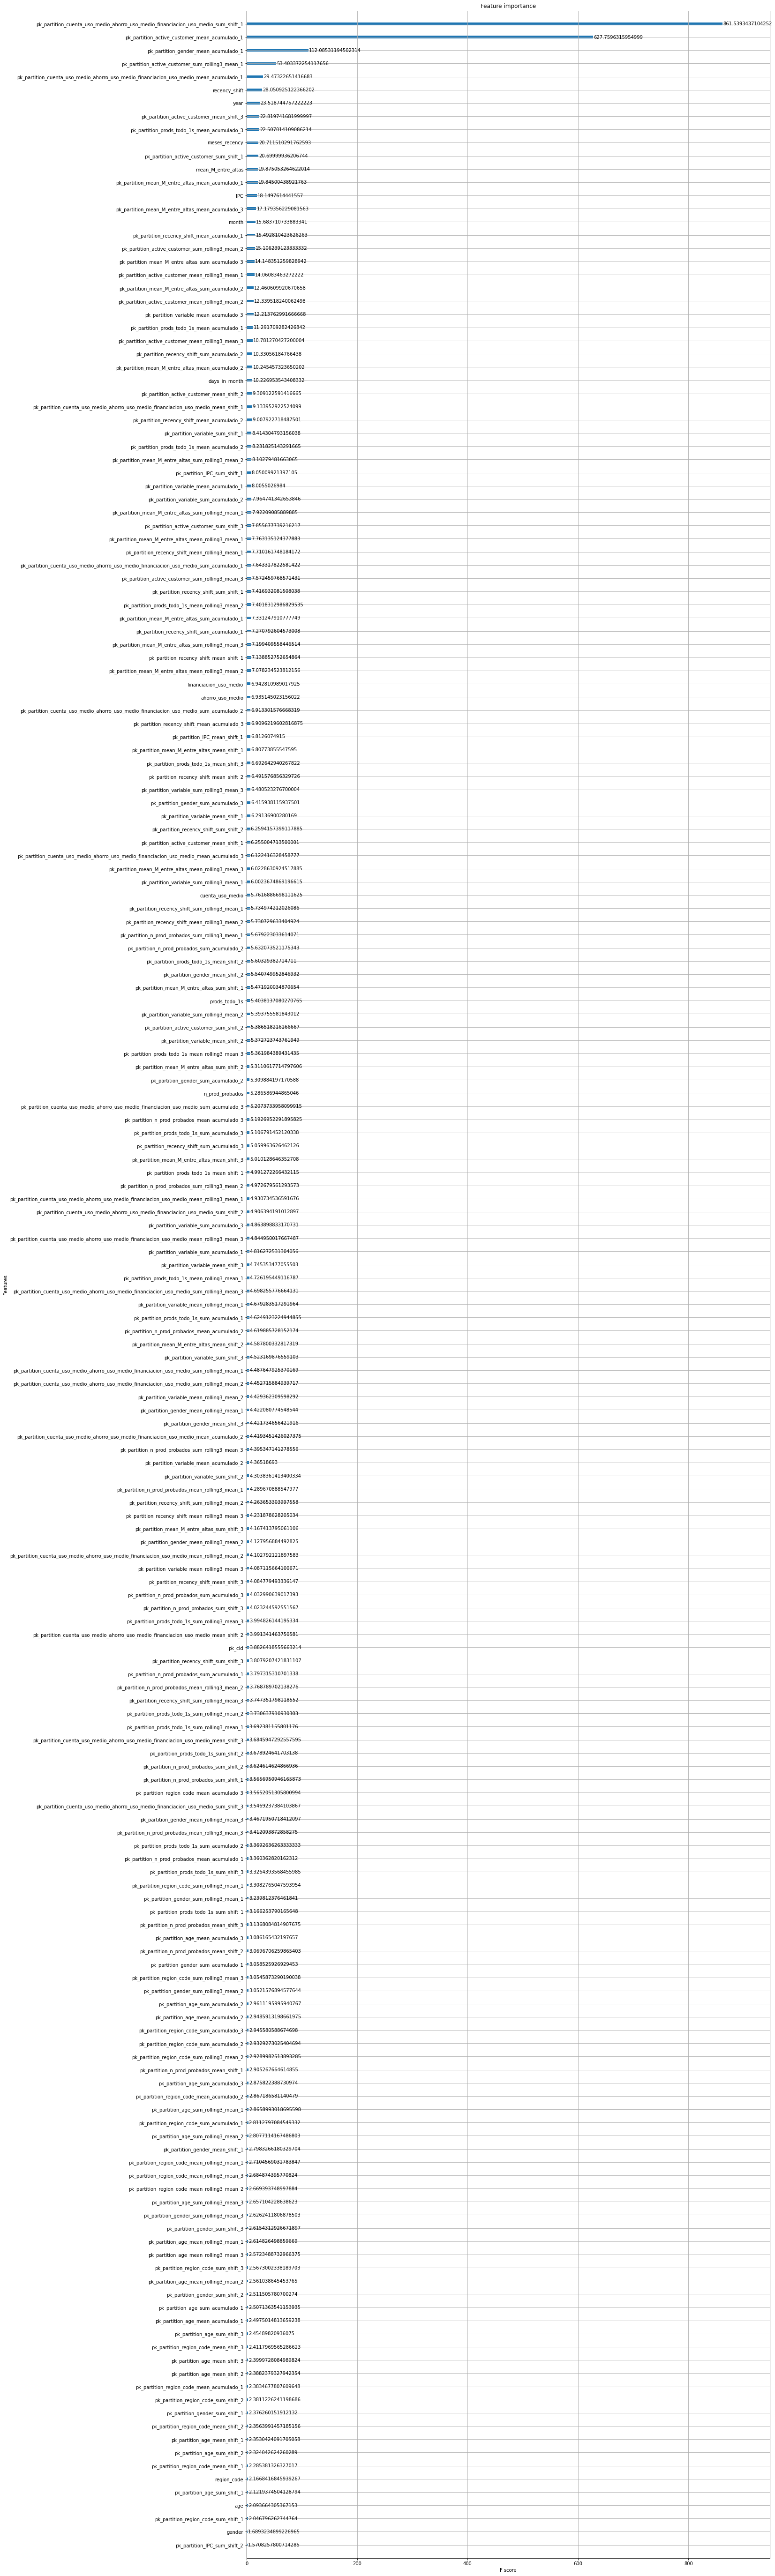

In [ ]:
importance = model.get_booster().get_score(importance_type = "gain")
importance = {k: v for k, v in sorted(importance.items(), key = lambda item: item[1])}

fig, ax = plt.subplots(figsize = (20, 100))
plot_importance(model, importance_type = "gain", ax = ax);

In [ ]:
pd.Series( model.feature_importances_, index=X_train.columns ).sort_values(ascending=False).head(30)

pk_partition_cuenta_uso_medio_ahorro_uso_medio_financiacion_uso_medio_sum_shift_1         0.306215
pk_partition_active_customer_mean_acumulado_1                                             0.223123
pk_partition_gender_mean_acumulado_1                                                      0.039838
pk_partition_active_customer_sum_rolling3_mean_1                                          0.018981
pk_partition_cuenta_uso_medio_ahorro_uso_medio_financiacion_uso_medio_mean_acumulado_1    0.010476
recency_shift                                                                             0.009970
year                                                                                      0.008359
pk_partition_active_customer_mean_shift_3                                                 0.008111
pk_partition_prods_todo_1s_mean_acumulado_3                                               0.008000
meses_recency                                                                             0.007361
pk_partiti

# Predict and model evaluation

El rmse (root mean square error) en el set de validación es de 0.25

In [ ]:
Y_valida_pred = model.predict(X_valida)

rmse_valida = sqrt(metrics.mean_squared_error(Y_valida, Y_valida_pred))
rmse_valida

0.2542704383699291

In [ ]:
Y_valida_pred

array([0., 1., 0., ..., 0., 0., 0.])

In [ ]:
X_valida_y = X_valida.copy(deep=True)

X_valida_y['prediccion'] = Y_valida_pred
X_valida_y['alta_real'] = Y_valida

Observamos que de los productos que no son de todo_1s y que tienen una alta para el set de validación, hay 11494 registros

In [ ]:
X_valida_short = X_valida_y[["pk_cid",'prods_todo_1s','cuenta_uso_medio',	'ahorro_uso_medio',	'financiacion_uso_medio', 'tipo_producto','price',"prediccion",'alta_real']]
X_valida_short[(X_valida_short.prods_todo_1s != 0) & (X_valida_short.alta_real == 1)]

,pk_cid,prods_todo_1s,cuenta_uso_medio,ahorro_uso_medio,financiacion_uso_medio,tipo_producto,price,prediccion,alta_real
34,20333,2.0,1.0,0.0,0.0,1,10,1.0,1.0
169,31624,2.0,0.0,1.0,0.0,0,40,1.0,1.0
187,31624,2.0,1.0,0.0,0.0,1,10,1.0,1.0
295,36148,2.0,1.0,0.0,0.0,1,10,1.0,1.0
466,51389,2.0,1.0,0.0,0.0,1,10,1.0,1.0
...,...,...,...,...,...,...,...,...,...
1177855,1546171,2.0,1.0,0.0,0.0,1,10,1.0,1.0
1177858,1546171,2.0,0.0,0.0,0.5,2,60,0.0,1.0
1177870,1546312,2.0,0.0,0.5,0.0,0,40,0.0,1.0
1177873,1546312,2.0,1.0,0.0,0.0,1,10,1.0,1.0


Que sean todo_1s==0 y que tengan una alta real, solo hay 3389 registros

In [ ]:
X_valida_short[(X_valida_short.prods_todo_1s == 0) & (X_valida_short.alta_real == 1)]

,pk_cid,prods_todo_1s,cuenta_uso_medio,ahorro_uso_medio,financiacion_uso_medio,tipo_producto,price,prediccion,alta_real
370,46507,0.0,0.000000,0.5,0.0,0,40,0.0,1.0
2099,144324,0.0,0.250000,0.0,0.0,1,10,0.0,1.0
3027,204467,0.0,0.666667,0.0,0.0,1,10,0.0,1.0
3910,256594,0.0,0.470588,0.0,0.0,1,10,0.0,1.0
3938,256855,0.0,0.250000,0.0,0.0,1,10,0.0,1.0
...,...,...,...,...,...,...,...,...,...
1178002,1547241,0.0,0.000000,0.0,0.5,2,60,1.0,1.0
1178005,1547294,0.0,0.000000,0.5,0.0,0,40,0.0,1.0
1178008,1547294,0.0,0.500000,0.0,0.0,1,10,1.0,1.0
1178014,1547431,0.0,0.000000,0.5,0.0,0,40,0.0,1.0


De los anteriores 3389, el modelo ha predecido como altas 291

In [ ]:
X_valida_short[(X_valida_short.prediccion == 1) & (X_valida_short.prods_todo_1s == 0) & (X_valida_short.alta_real == 1)]

,pk_cid,prods_todo_1s,cuenta_uso_medio,ahorro_uso_medio,financiacion_uso_medio,tipo_producto,price,prediccion,alta_real
4783,296407,0.0,0.0,0.0,0.464286,2,60,1.0,1.0
14082,697327,0.0,0.0,0.5,0.000000,0,40,1.0,1.0
16539,799832,0.0,0.0,0.5,0.000000,0,40,1.0,1.0
19395,875239,0.0,0.0,0.5,0.000000,0,40,1.0,1.0
19702,883936,0.0,0.0,0.5,0.000000,0,40,1.0,1.0
...,...,...,...,...,...,...,...,...,...
1177981,1547023,0.0,0.5,0.0,0.000000,1,10,1.0,1.0
1177990,1547173,0.0,0.5,0.0,0.000000,1,10,1.0,1.0
1177999,1547241,0.0,0.5,0.0,0.000000,1,10,1.0,1.0
1178002,1547241,0.0,0.0,0.0,0.500000,2,60,1.0,1.0


De los todo_1s diferentes de 0s con alta (11494), el modelo ha predecido bien 10432

In [ ]:
X_valida_short[(X_valida_short.prediccion == 1) & (X_valida_short.prods_todo_1s != 0) & (X_valida_short.alta_real == 1)]

,pk_cid,prods_todo_1s,cuenta_uso_medio,ahorro_uso_medio,financiacion_uso_medio,tipo_producto,price,prediccion,alta_real
34,20333,2.0,1.0,0.0,0.00,1,10,1.0,1.0
169,31624,2.0,0.0,1.0,0.00,0,40,1.0,1.0
187,31624,2.0,1.0,0.0,0.00,1,10,1.0,1.0
295,36148,2.0,1.0,0.0,0.00,1,10,1.0,1.0
466,51389,2.0,1.0,0.0,0.00,1,10,1.0,1.0
...,...,...,...,...,...,...,...,...,...
1177723,1545175,3.0,0.0,0.0,0.75,2,60,1.0,1.0
1177852,1546171,2.0,0.0,1.0,0.00,0,40,1.0,1.0
1177855,1546171,2.0,1.0,0.0,0.00,1,10,1.0,1.0
1177873,1546312,2.0,1.0,0.0,0.00,1,10,1.0,1.0


En total en el set de validación hay (11494 + 3389) 14.883 altas reales.

In [ ]:
X_valida_short[(X_valida_short.alta_real == 1)]

,pk_cid,prods_todo_1s,cuenta_uso_medio,ahorro_uso_medio,financiacion_uso_medio,tipo_producto,price,prediccion,alta_real
34,20333,2.0,1.0,0.0,0.0,1,10,1.0,1.0
169,31624,2.0,0.0,1.0,0.0,0,40,1.0,1.0
187,31624,2.0,1.0,0.0,0.0,1,10,1.0,1.0
295,36148,2.0,1.0,0.0,0.0,1,10,1.0,1.0
370,46507,0.0,0.0,0.5,0.0,0,40,0.0,1.0
...,...,...,...,...,...,...,...,...,...
1178002,1547241,0.0,0.0,0.0,0.5,2,60,1.0,1.0
1178005,1547294,0.0,0.0,0.5,0.0,0,40,0.0,1.0
1178008,1547294,0.0,0.5,0.0,0.0,1,10,1.0,1.0
1178014,1547431,0.0,0.0,0.5,0.0,0,40,0.0,1.0


*   Hay 57.936 0s y 148.83 altass (72.819 registros en total).
  *   Hay 3389 altas en todo1s==0 en el set de validacion
  *   Hay 11494 altas de todo1s != 0

*   El modelo ha predecido 291 todo0s como 1s que eran altas reales (TP CORRECTO 8,5%)
*   El modelo ha predecido 469 todo0s como 1s que eran 0s (FP MAL 469/3389 = 13,82%)
*   El modelo ha predeciso 3098 0s en todo0s que erena altas reales
*   El modelo ha predecido 10432 todo1s con altas que eran altas reales (CORRECTO 90.7%)


In [ ]:
X_valida_short[(X_valida_short.prediccion == 1) & (X_valida_short.prods_todo_1s == 0) & (X_valida_short.alta_real == 1) & (X_valida_short.tipo_producto == 1)]

,pk_cid,prods_todo_1s,cuenta_uso_medio,ahorro_uso_medio,financiacion_uso_medio,tipo_producto,price,prediccion,alta_real
171433,1054523,0.0,0.882353,0.0,0.0,1,10,1.0,1.0
197254,1066307,0.0,0.882353,0.0,0.0,1,10,1.0,1.0
218563,1078820,0.0,0.500000,0.0,0.0,1,10,1.0,1.0
293215,1114942,0.0,0.500000,0.0,0.0,1,10,1.0,1.0
332104,1123261,0.0,0.147059,0.0,0.0,1,10,1.0,1.0
...,...,...,...,...,...,...,...,...,...
1177963,1546993,0.0,0.500000,0.0,0.0,1,10,1.0,1.0
1177981,1547023,0.0,0.500000,0.0,0.0,1,10,1.0,1.0
1177990,1547173,0.0,0.500000,0.0,0.0,1,10,1.0,1.0
1177999,1547241,0.0,0.500000,0.0,0.0,1,10,1.0,1.0


### Confusion Matrix

Sacamos la matriz de confusión para ver resultados

In [ ]:
def confusion_matrix_figure(y_test, y_pred):
    fig, ax = plt.subplots(figsize=(8,8))

    cf_matrix = confusion_matrix(y_test, y_pred)
    cf_matrix_ = cf_matrix.copy()
    cf_matrix_[1,1] = cf_matrix[0,0]
    cf_matrix_[0,1] = cf_matrix[1,0]
    cf_matrix_[0,0] = cf_matrix[1,1]
    cf_matrix_[1,0] = cf_matrix[0,1]
    cf_matrix_

    group_names = ['True Pos','False Neg','False Pos','True Neg']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix_.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix_.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)
    ax = sns.heatmap(cf_matrix_, annot=labels, fmt='', cmap='Greens', annot_kws={"size": 20},
                    yticklabels=['Positive','Negative'], xticklabels=['Positive','Negative'])
    ax.set_xlabel('Predicted',fontsize=23)
    ax.set_ylabel('Real',fontsize=23)
    ax.tick_params(labelsize=20)
    
    return fig

----------- VALIDATION -----------
Accuracy: 0.9353465441711641
Precision: 0.951379646881377
Recall: 0.7204864610629578
F1-score: 0.8199892941806225
ROC AUC score: 0.9658815743142641


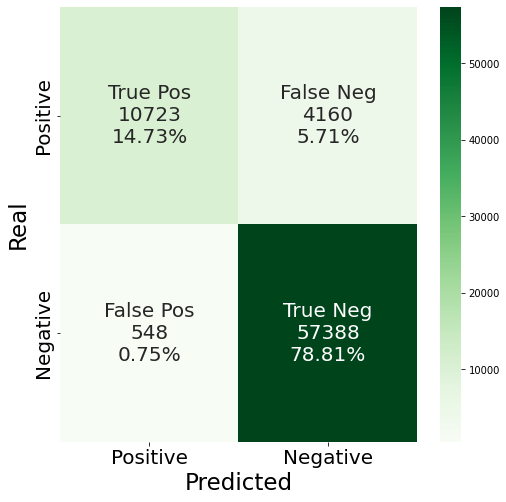

In [ ]:
y_valida_score = model.predict_proba(X_valida)[:,1]

print("----------- VALIDATION -----------")
print("Accuracy:",accuracy_score(Y_valida, Y_valida_pred))
print("Precision:",precision_score(Y_valida, Y_valida_pred))
print("Recall:",recall_score(Y_valida, Y_valida_pred))
print("F1-score:",f1_score(Y_valida, Y_valida_pred))
print("ROC AUC score:",roc_auc_score(Y_valida, y_valida_score))

fig = confusion_matrix_figure(Y_valida, Y_valida_pred)
fig.show()

Vemos que las métricas de accuracy, precision, recall, etc son buenas. El problema en este dataset es el desbalanceo de clases, que general el problema del Accuracy Paradox. Al tener tantos 0s en el target y al predecirlos correctamente, el modelo obtiene buenas métricas, pero si analizamos en detalle solo las altas que nos interesan vemos que las métricas no son tan buenas.

Los True Positive son solo del 14% (y esto contando que dentro también están las altas en productos con todo_1s, que no reportarían beneficios). De los cálculos anteriores hemos visto que predice correctamente el 8,5% de las altas en prodcutos con todo_1s==0, así que este procentaje es el que usaremos para calcular los beneficios obtenidos en la parte de recomendación.

## Predicciones Test

Calculamos las predicciones de nuestro modelo en el set de test (el mes a predecir)

In [ ]:
Y_test_pred = model.predict(X_test)

In [ ]:
X_test_y = X_test.copy(deep=True)

X_test_y['prediccion'] = Y_test_pred


In [ ]:
X_test_short = X_test_y[["pk_cid",'prods_todo_1s','cuenta_uso_medio',	'ahorro_uso_medio',	'financiacion_uso_medio','price', 'tipo_producto',"prediccion"]]

In [ ]:
X_test_short.tail(50)

,pk_cid,prods_todo_1s,cuenta_uso_medio,ahorro_uso_medio,financiacion_uso_medio,price,tipo_producto,prediccion
1177874,1546312,2.0,1.0,0.0,0.0,10,1,1.0
1177877,1546312,2.0,0.0,0.0,1.0,60,2,1.0
1177880,1546379,0.0,0.0,0.5,0.0,40,0,0.0
1177883,1546379,0.0,0.5,0.0,0.0,10,1,0.0
1177886,1546379,0.0,0.0,0.0,0.0,60,2,0.0
1177889,1546460,0.0,0.0,0.5,0.0,40,0,0.0
1177892,1546460,0.0,0.5,0.0,0.0,10,1,0.0
1177895,1546460,0.0,0.0,0.0,0.5,60,2,0.0
1177898,1546469,0.0,0.0,0.5,0.0,40,0,0.0
1177901,1546469,0.0,0.5,0.0,0.0,10,1,0.0


In [ ]:
X_test_short[(X_test_short.prediccion == 1) & (X_test_short.prods_todo_1s != 1)]

,pk_cid,prods_todo_1s,cuenta_uso_medio,ahorro_uso_medio,financiacion_uso_medio,price,tipo_producto,prediccion
35,20333,2.0,1.0,0.0,0.0,10,1,1.0
170,31624,2.0,0.0,1.0,0.0,40,0,1.0
188,31624,2.0,1.0,0.0,0.0,10,1,1.0
296,36148,2.0,1.0,0.0,0.0,10,1,1.0
374,46507,0.0,0.5,0.0,0.0,10,1,1.0
...,...,...,...,...,...,...,...,...
1177799,1545646,0.0,0.0,0.5,0.0,40,0,1.0
1177853,1546171,2.0,0.0,1.0,0.0,40,0,1.0
1177856,1546171,2.0,1.0,0.0,0.0,10,1,1.0
1177874,1546312,2.0,1.0,0.0,0.0,10,1,1.0


El modelo ha predecido 1701 productos como altas en prodcutos que no provienen de todo_1s, osea productos que darían beneficio. Que siguiendo los cálculos del set de validación, podríamos pensar que solo un 8,5% de estas predicciones es correcta.

In [ ]:
X_test_short[(X_test_short.prediccion == 1) & (X_test_short.prods_todo_1s == 0)]

,pk_cid,prods_todo_1s,cuenta_uso_medio,ahorro_uso_medio,financiacion_uso_medio,price,tipo_producto,prediccion
374,46507,0.0,0.500000,0.0,0.000000,10,1,1.0
4583,287097,0.0,0.500000,0.0,0.000000,10,1,1.0
4983,307190,0.0,0.000000,0.5,0.000000,40,0,1.0
4990,307190,0.0,0.416667,0.0,0.000000,10,1,1.0
5988,374423,0.0,0.354167,0.0,0.000000,10,1,1.0
...,...,...,...,...,...,...,...,...
1177355,1542269,0.0,0.000000,0.0,0.666667,60,2,1.0
1177502,1543230,0.0,0.000000,0.5,0.000000,40,0,1.0
1177511,1543237,0.0,0.000000,0.5,0.000000,40,0,1.0
1177796,1545592,0.0,0.000000,0.0,0.500000,60,2,1.0


In [ ]:
X_test_short[(X_test_short.prediccion == 1)].shape

(12287, 8)

Distribución de las predicciones según tipo de producto

In [ ]:
X_test_short[(X_test_short.prediccion == 1)]['tipo_producto'].value_counts()

1    6370
2    3519
0    2398
Name: tipo_producto, dtype: int64

### ROI

Esto sería el beneficio obtenido suponiendo que todas las predicciones de nuestro modelo son 100% fiables y que por tanto obtendremos el beneficio para todos los productos. Obviamente esto no será así.

In [ ]:
X_test_short[(X_test_short.prediccion == 1) & (X_test_short.prods_todo_1s == 0)]['price'].sum()

60170

# Cruce con Recomendaciones

Importamos el pickle con las 10k recomendaciones de productos que se han calculado en la tarea 3 del proyecto

In [ ]:
recomendaciones= '/content/drive/MyDrive/DATA SCIENCE/Nuclio DS/Capstone NDS/3. Recomendacion/lista_recomendacion.pkl'

In [ ]:
import pickle

with open(recomendaciones, 'rb') as handle:
    recs = pickle.load(handle)

In [ ]:
recs

,Cliente,Recomendacion
0,1050686,payroll_account
1,1050660,em_acount
2,1050651,em_acount
3,1050652,pension_plan
5,1050565,emc_account
...,...,...
10053,1433369,em_acount
10054,1428596,em_acount
10055,1437442,em_account_p
10056,1442421,long_term_deposit


Pasamos los productos a tipo de producto para poder realizar el cruce.

In [ ]:
recs['tipo_prod'] = 0

In [ ]:
buckets =   {'cuenta' : ['em_acount', 'em_account_p','emc_account', 'payroll_account'],
             'ahorro':  ['funds', 'pension_plan', 'short_term_deposit', 'long_term_deposit', 'securities'],
             'financiacion': ['loans', 'mortgage', 'debit_card', 'credit_card']}
    
recs['tipo_prod'] = 0

for idx in recs.index:
  if recs['Recomendacion'][idx] in buckets.get('cuenta'):
    recs['tipo_prod'][idx] = 'cuenta'
  elif recs['Recomendacion'][idx] in buckets.get('ahorro'):
    recs['tipo_prod'][idx] = 'ahorro'
  elif recs['Recomendacion'][idx] in buckets.get('financiacion'):
    recs['tipo_prod'][idx] = 'financiacion'


Según el modelo de recomendación sale la siguiente distribución

In [ ]:
recs['tipo_prod'].value_counts()

cuenta          6398
ahorro          2685
financiacion     917
Name: tipo_prod, dtype: int64

In [ ]:
pred_compra = X_test_short[['pk_cid', 'price', 'tipo_producto', 'prediccion']]

In [ ]:
pred_compra

,pk_cid,price,tipo_producto,prediccion
17,20333,40,0,0.0
35,20333,10,1,1.0
53,20333,60,2,0.0
68,21719,40,0,0.0
83,21719,10,1,0.0
...,...,...,...,...
1178009,1547294,10,1,0.0
1178012,1547294,60,2,0.0
1178015,1547431,40,0,0.0
1178018,1547431,10,1,0.0


In [ ]:
pred_compra['tipo_producto'] = np.where(pred_compra.price == 10, 'cuenta', pred_compra['tipo_producto'])
pred_compra['tipo_producto'] = np.where(pred_compra.price == 40, 'ahorro', pred_compra['tipo_producto'])
pred_compra['tipo_producto'] = np.where(pred_compra.price == 60, 'financiacion', pred_compra['tipo_producto'])

In [ ]:
pred_compra

,pk_cid,price,tipo_producto,prediccion
17,20333,40,ahorro,0.0
35,20333,10,cuenta,1.0
53,20333,60,financiacion,0.0
68,21719,40,ahorro,0.0
83,21719,10,cuenta,0.0
...,...,...,...,...
1178009,1547294,10,cuenta,0.0
1178012,1547294,60,financiacion,0.0
1178015,1547431,40,ahorro,0.0
1178018,1547431,10,cuenta,0.0


Merge entre las recomendaciones y las predicciones de alta del modelo de compra.

In [ ]:
mg = pd.merge(recs, pred_compra[pred_compra.prediccion == 1], right_on=['pk_cid', 'tipo_producto'], left_on=['Cliente', 'tipo_prod'], how='left')

De todas las recomendaciones y de las predicciones como compra del mes próximo, coinciden 2909 registros. 
Estos registros son donde coincide que la recomendación del producto a hacerles y la predicción de compra para ese cliente y ese tipo de producto es una predicción de compra/de darse de alta.

In [ ]:
mg[mg.prediccion == 1]

,Cliente,Recomendacion,tipo_prod,pk_cid,price,tipo_producto,prediccion
0,1050686,payroll_account,cuenta,1050686.0,10.0,cuenta,1.0
1,1050660,em_acount,cuenta,1050660.0,10.0,cuenta,1.0
2,1050651,em_acount,cuenta,1050651.0,10.0,cuenta,1.0
10,1050091,em_acount,cuenta,1050091.0,10.0,cuenta,1.0
13,1051968,em_acount,cuenta,1051968.0,10.0,cuenta,1.0
...,...,...,...,...,...,...,...
9982,1399618,emc_account,cuenta,1399618.0,10.0,cuenta,1.0
9987,1403295,emc_account,cuenta,1403295.0,10.0,cuenta,1.0
9992,1405769,payroll_account,cuenta,1405769.0,10.0,cuenta,1.0
9998,1442421,long_term_deposit,ahorro,1442421.0,40.0,ahorro,1.0


Filtrando el precio que obtendríamos si estos clientes se dieran de alta, obtenemos un beneficio de 37k. Del cual para la presentación a CEO calcularemos el 8,5% de acierto del modelo, lo que es unos 3k.

In [ ]:
mg[mg.prediccion == 1]['price'].sum()

37280.0

In [ ]:
pred_compra[pred_compra.pk_cid == 1050660]

,pk_cid,price,tipo_producto,prediccion
162218,1050660,40,ahorro,0.0
162236,1050660,10,cuenta,1.0
162254,1050660,60,financiacion,0.0


In [ ]:
recs[recs.Cliente == 1050660]

,Cliente,Recomendacion,tipo_prod
1,1050660,em_acount,cuenta


Distribución de los tipos de productos con predicción de compra y que coinciden con la recomendación de la tarea 3.

In [ ]:
mg.tipo_producto.value_counts()

cuenta          2660
ahorro           213
financiacion      36
Name: tipo_producto, dtype: int64

# Conclusiones

Se han probado diferentes tipos de enfoque para poder realizar la predicción de compra y este modelo, aunque tenga un % de acierto de altas muy bajo, es el mejor modelo obtenido.

Se ha jugado mucho con la creación de variables, la imputación de nulos, altas y cómo moldear el dataset para poder llevar a cabo el modelo de predicción en poco tiempo. Con más tiempo, modelos más complejos y incorporando soluciones específicas para casos desbalanceados en time series para fintech, estamos seguros que se podría mejorar.

La previsión de un ROI de 3k es el peor escenario posible, ya que esto es contemplando que ninguna de las recomendaciones de producto que no coinciden con altas, se conviertan en una.